## Credit Score Classification

$by: Jeremiah\space Chinyelugo$

In this project, we will be creating a multi-class classifier, capable of predicting the credit score of customers in a bank.

The data used for this project contains a lot of outliers, missing values and dirty data. So, the majority of this notebook will be about cleaning and preprocessing the data.

#### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA

from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score

#### Loading the dataset

In [2]:
df = pd.read_csv("./Classification/1.0 archive/train.csv")
df.head()

C:\Users\jerem\AppData\Local\Temp\ipykernel_19080\3975851574.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Classification/1.0 archive/train.csv")


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529544,High_spent_Small_value_payments,312.4940887,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.2802216,Low_spent_Large_value_payments,284.6291625,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.69952126,Low_spent_Medium_value_payments,331.2098629,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580744,Low_spent_Small_value_payments,223.4513097,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.42015309,High_spent_Medium_value_payments,341.489231,Good


In [3]:
# Understanding the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

**Dropping irrelevant columns**

We are going to drop the the ID, Name, Customer ID and SSN columns because we are trying to create a Credit score classifier that can generalize.

We could decide to leave the Customer ID feature, which will no doubt increase our model accuracy, but the aim of this project is create a classifier that can be used for other customers in maybe another branch.

In [4]:
# dropping irrelevant columns

df.drop(['ID', 'Customer_ID', 'Month', 'Name', 'SSN'], axis=1, inplace=True)

In [5]:
# checking for null values in our dataset

df.isnull().sum()

Age                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

## Data Processing

In this section, we will preprocess our data. Having looked through our data, i discovered that its riddled with outliers and dirty instances we need to address before we proceed with modeling. So this section will be a lot ass we will be cleaning each of our feature.

**1. Age**

In [6]:
# checking our Age feature

df['Age'][1015:1025]

1015     15
1016     29
1017     30
1018    30_
1019     30
1020     30
1021     30
1022     30
1023     30
1024     41
Name: Age, dtype: object

Our Age feature dtype is an object and some instances have and underscore attached to them that we have to remove

In [7]:
# creating function to remove underscores and convert strings to numerical

def clean_feature(value):
    try:
        value = float(value)
    except ValueError:
        value = value.strip('_')
        value = float(value)
    return value

In [8]:
# applying function

df['Age'] = df['Age'].map(lambda x: int(clean_feature(x)))

In [9]:
df['Age'][:5]

0     23
1     23
2   -500
3     23
4     23
Name: Age, dtype: int64

In [10]:
# let's look at the description of our dataset

df['Age'].describe()

count    100000.000000
mean        110.649700
std         686.244717
min        -500.000000
25%          24.000000
50%          33.000000
75%          42.000000
max        8698.000000
Name: Age, dtype: float64

from our data description, our minimum and maximum values are -500 and 8,698 respectively. That obviously makes no sense, so we will try to figure out the lowest age in our dataset when we exclude any age less than 0.

In [11]:
# look for minimum age when we filter out ages less than 0

df[~df['Age'].between(-500,0)]['Age'].min()

14

In [12]:
# look for maximum age when we filter out ages greater than 99

df[~df['Age'].between(100,8698)]['Age'].max()

99

rather than deleting those instances where we clearly have outliers, we will set any value above 99 years to 99, and any value less than 0 years to 14.

In [13]:
df['Age'] = np.where(df['Age'].between(-500, 0), 14, df['Age'])
df['Age'] = np.where(df['Age'].between(100, 8698), 99, df['Age'])

In [14]:
# creating a helper function for plotting Kernel density

def kde_plot(feature):
    plt.figure(figsize=(12,8))
    sns.kdeplot(feature)
    plt.title(f"Kernel density plot of the {feature.name} feature", fontsize=15, weight='bold')
    plt.show()

In [15]:
# creating a helper function for plotting Kernel density & Box plot

def plot_feature(feature):
    fig, ax = plt.subplots(1,2, figsize=(24,8))
    sns.kdeplot(feature, ax=ax[0])
    ax[0].set_title(f"Kernel density plot of the {feature.name} feature", fontsize=15, weight='bold')
    sns.boxplot(feature, ax=ax[1])
    ax[1].set_title(f"Box plot of the {feature.name} feature", fontsize=15, weight='bold')
    plt.show()

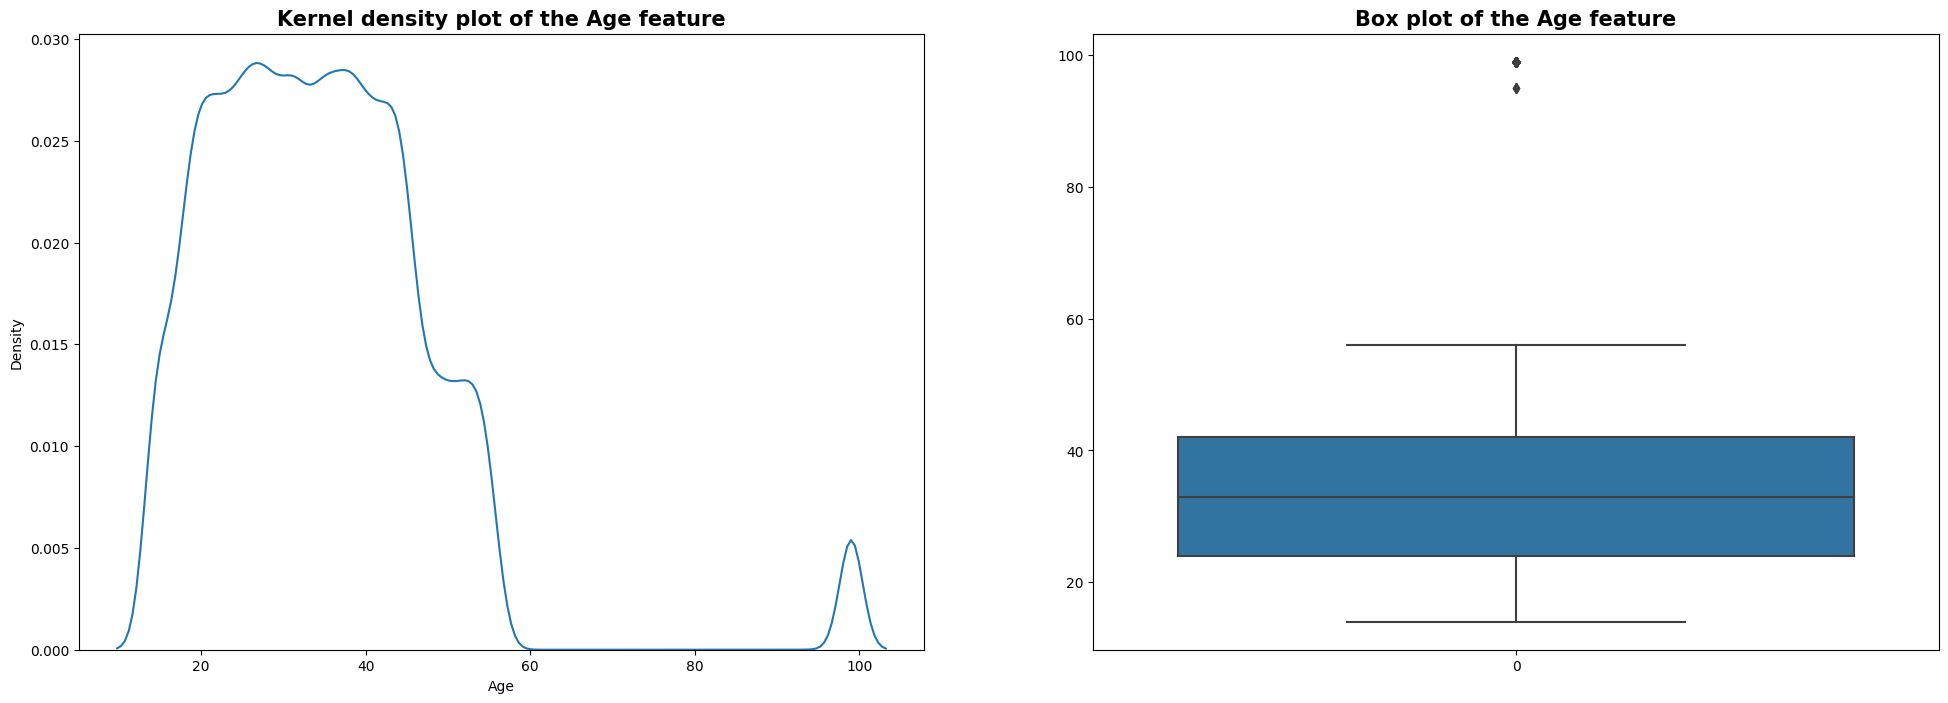

In [16]:
plot_feature(df['Age'])

We could use the Age feature as is, or we could create Age classes based age range which could improve model accuracy, so let's do that.

In [17]:
# creating age classes for our age

df['Age_class'] = pd.cut(df['Age'], bins=[float('-inf'), 21, 35, 45, 60, 100], labels=['Young', 'Young Adult', 'Middle Aged', 'Mature Adults', 'Senior'])

**2. Occupation**

In [18]:
# checking unique values

df['Occupation'].value_counts()

Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

Our occupation feature is categorical, so we will create dummie variables latter on in this notebook, but first we need to replace `_______` with Not Specified as we are not sure what it signifies.

In [19]:
# cleaning up data

df['Occupation'] = np.where(df['Occupation'] == '_______', 'Not Specified', df['Occupation'])
df['Occupation'].value_counts()

Occupation
Not Specified    7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

**3. Annual Income**

In [20]:
# checking if we have null values

df['Annual_Income'].isnull().sum()

0

In [21]:
# checking its data type

df['Annual_Income'].dtype

dtype('O')

Our Annual income feature is an object so we need to apply the cleaning function we created earlier

In [22]:
# cleaning up the Annual Income

df['Annual_Income'] = df['Annual_Income'].map(lambda x: clean_feature(x))

In [23]:
df['Annual_Income'].describe()

count    1.000000e+05
mean     1.764157e+05
std      1.429618e+06
min      7.005930e+03
25%      1.945750e+04
50%      3.757861e+04
75%      7.279092e+04
max      2.419806e+07
Name: Annual_Income, dtype: float64

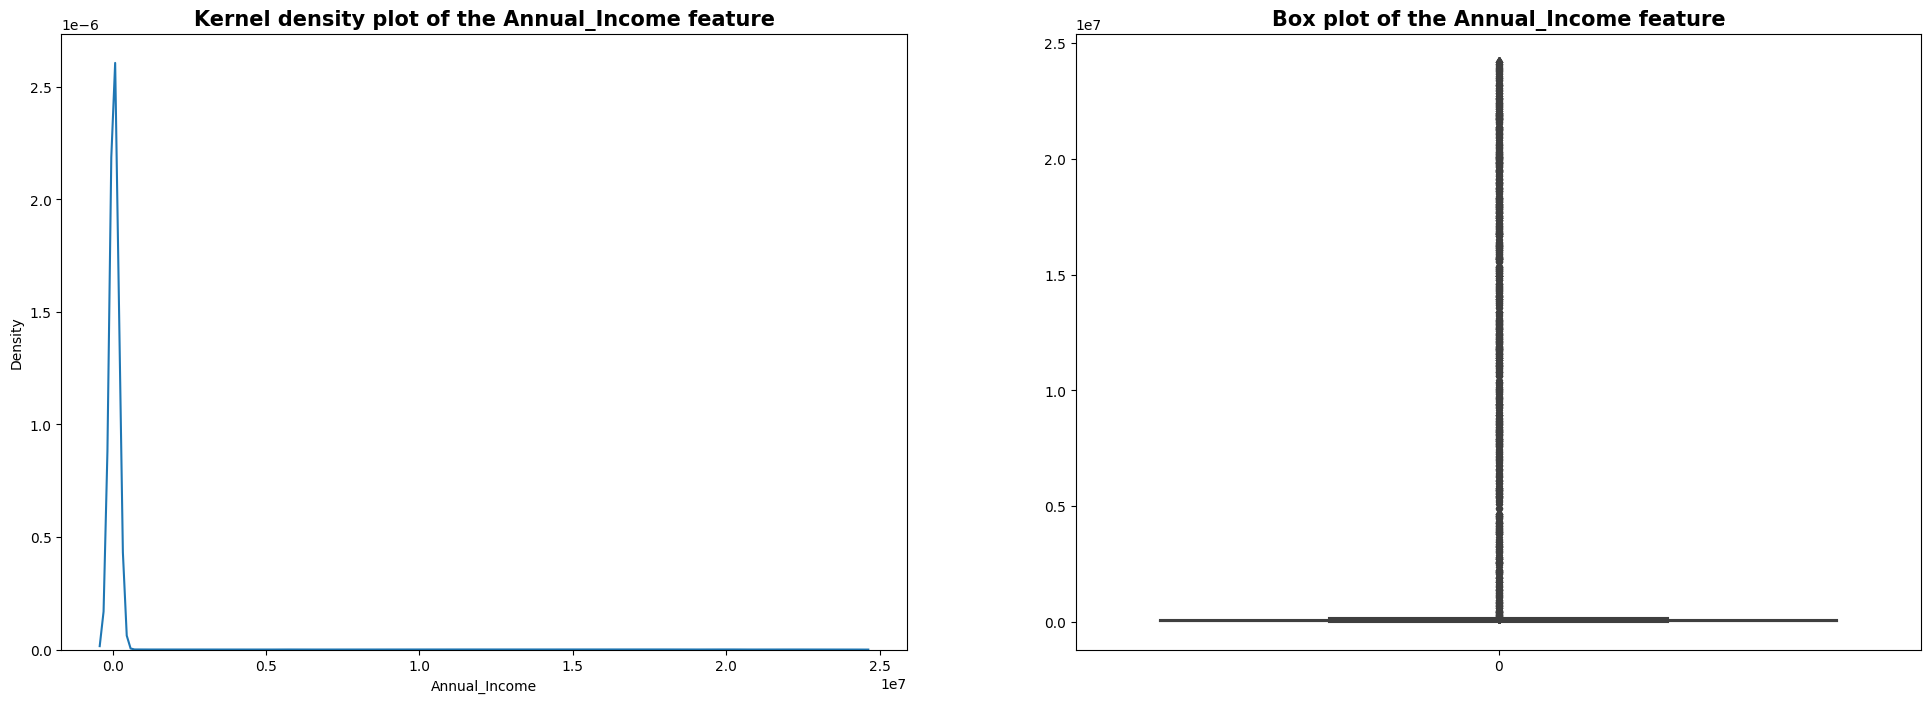

In [24]:
# visualizing the data

plot_feature(df['Annual_Income'])

From the plots above, we can see that we have extreme outliers. We could decide to clip the values by setting any value above a threshold to a value or we could delete outliers. Having tried both options here, i saw better model accuracy (5%) by removing the outliers, so that's what we'll do next.

In [25]:
# creating a helper function to handle outliers

def process_outliers(feature):
    feature = feature.map(lambda x: clean_feature(x))
    
    pct_25 = np.percentile(feature, 25)
    pct_50 = np.percentile(feature, 50)
    pct_75 = np.percentile(feature, 75)
    IQR = pct_75 - np.percentile(feature, 25)
    lower_whisker = pct_25 - 1.5*IQR
    upper_whisker = 1.5*IQR + pct_75
    
    return df[feature.between(lower_whisker, upper_whisker)]

In [26]:
# applying the function 

df = process_outliers(df['Annual_Income'])

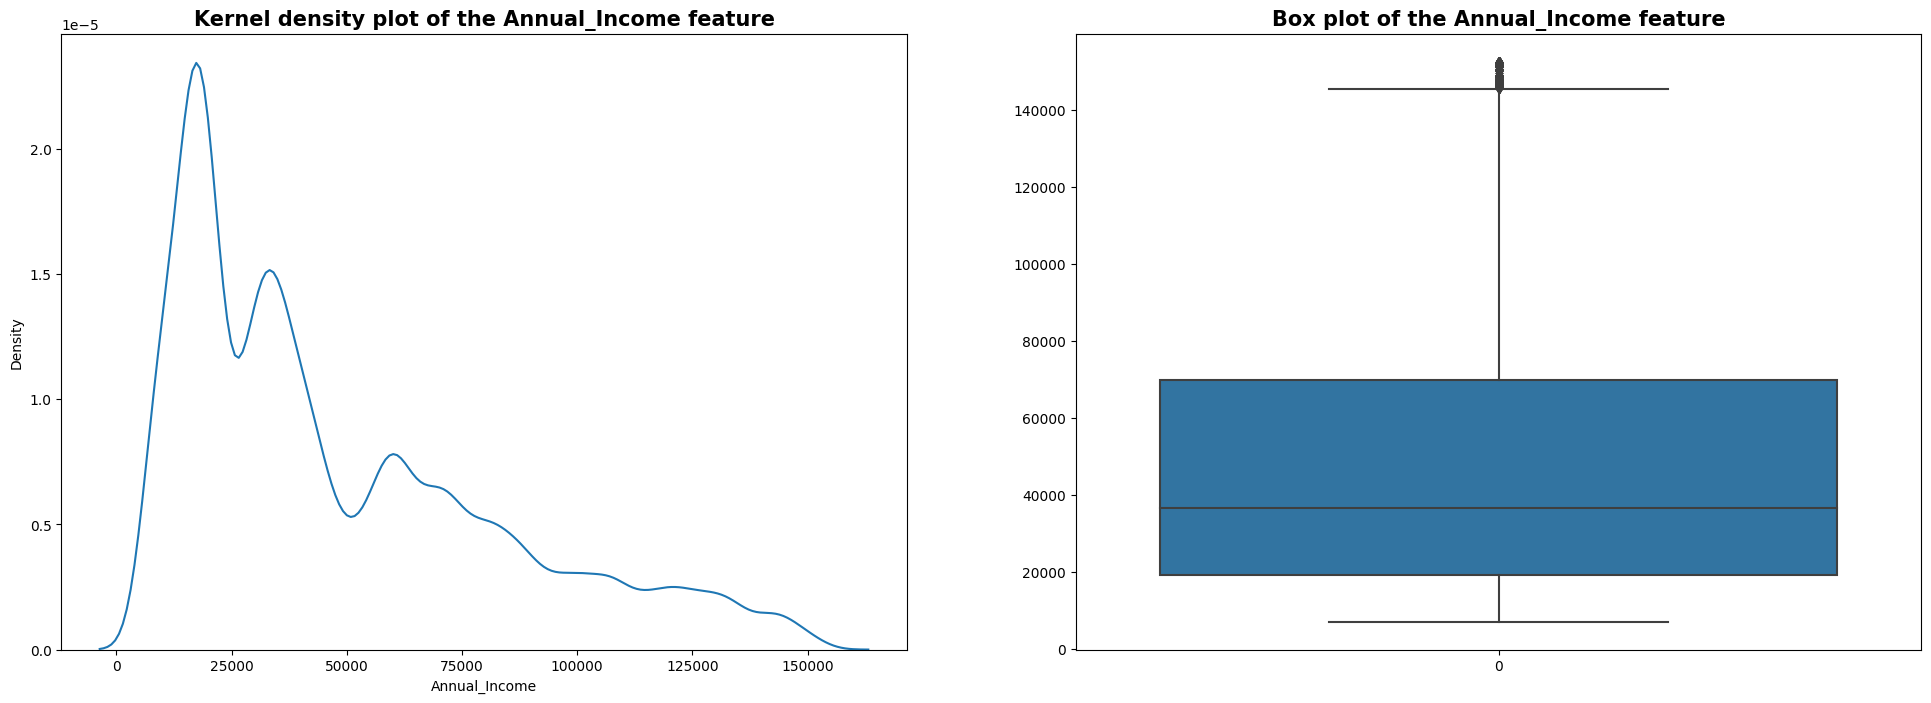

In [27]:
# visualizing the data

plot_feature(df['Annual_Income'])

In [28]:
print(f"By removing the outliers, we only removed {100_000 - df.shape[0]:,} instances")

By removing the outliers, we only removed 2,783 instances


The data looks so much better

**4. Monthly Inhand Income**

In [29]:
print(f"We have {df['Monthly_Inhand_Salary'].isnull().sum():,} missing values")

We have 14,558 missing values


We will drop the Monthly Income Salary feature because have 15,000+ missing values and it is not worth spending much time handling 15k+ values when we can use the Annual Income feature instead as a proxy

In [30]:
# dropping the feature 

df.drop(['Monthly_Inhand_Salary'], axis=1, inplace=True)

**5. No. Bank Accounts**

In [31]:
df['Num_Bank_Accounts'].describe()

count    97217.000000
mean        17.137949
std        117.456991
min         -1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max       1798.000000
Name: Num_Bank_Accounts, dtype: float64

Our data has a min value of -1, and a max value of 1,798

we are going to clip our instance just like we did earlier. Before we do, let's visualize our data

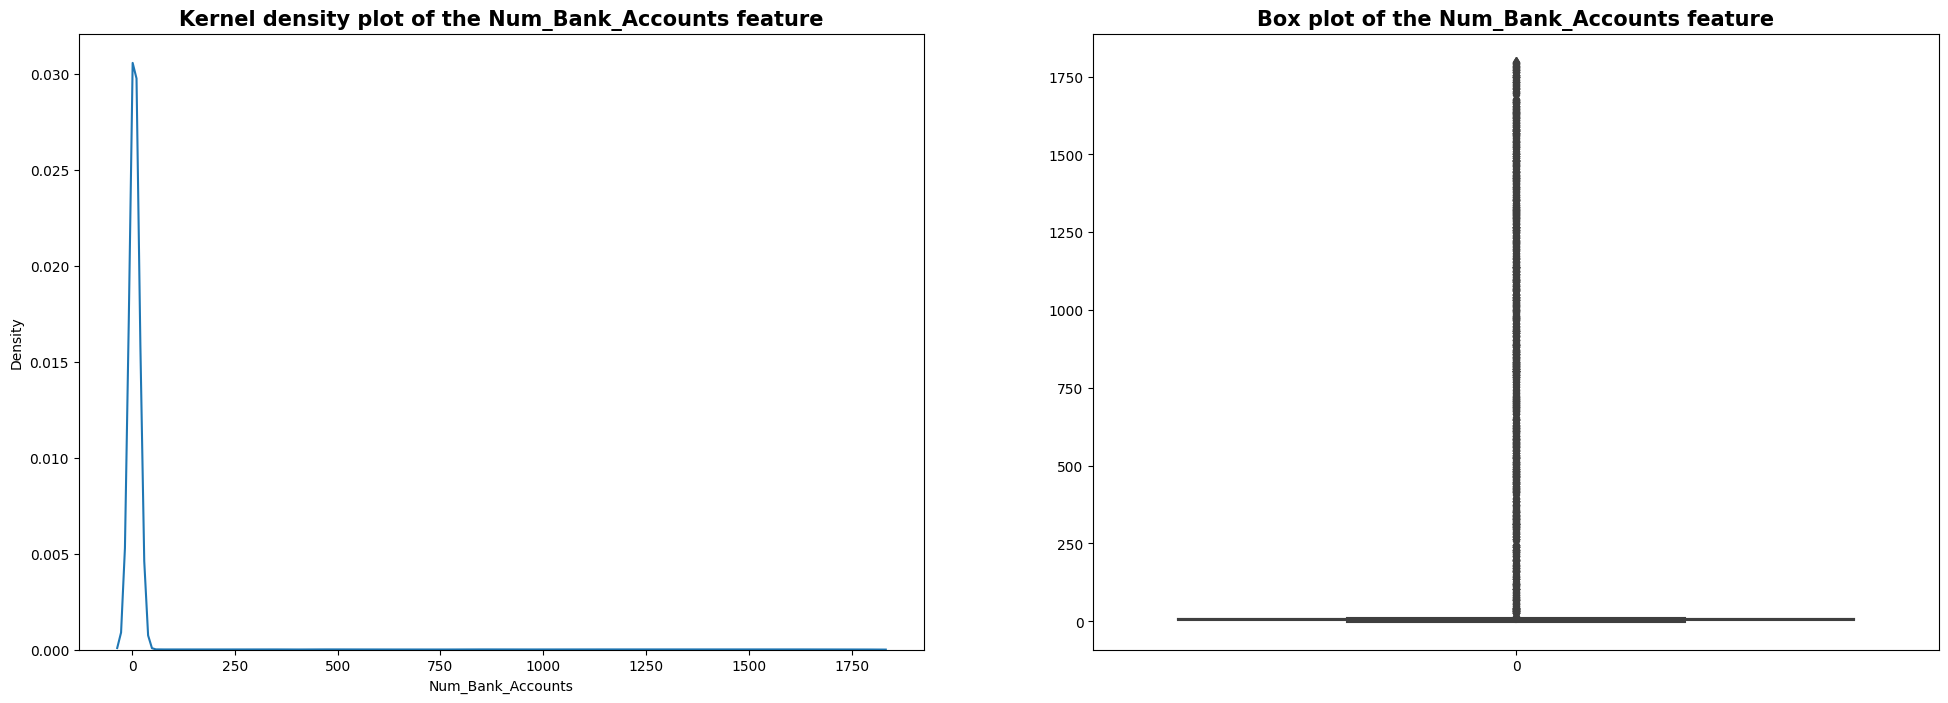

In [32]:
plot_feature(df['Num_Bank_Accounts'])

We have a similar plot to the Annual income, but rather than deleting outliers like we did earlier, we will clip our values.

Why? well in this case, we know that it's virtually impossible for a customer to open more than 100 accounts in a single bank. So rather than deleting those instances and reducing our dataset further, we'll just clip the values.
In the Annual Income scenario, it is possible for 1%'ers to earn large amounts of money but including clipping those instances could degrade model performance as those instances have corresponding features that mnay degrade model performance.

In [33]:
# look for minimum age when we filter out ages less than 0

df[~df['Num_Bank_Accounts'].between(-1,0)]['Num_Bank_Accounts'].min()

1

In [34]:
# look for maximum age when we filter out ages greater than 99

df[~df['Num_Bank_Accounts'].between(10,2000)]['Num_Bank_Accounts'].max()

9

we will clip number of accounts to the range of 1 and 10

In [35]:
def clip_bank_accts(feature):
    feature = np.where(feature.between(-2,0), 1, feature)
    feature = pd.Series(feature)
    feature = np.where(feature.between(10,2000), 10, feature)
    return feature

In [36]:
df['Num_Bank_Accounts'] = clip_bank_accts(df['Num_Bank_Accounts'])

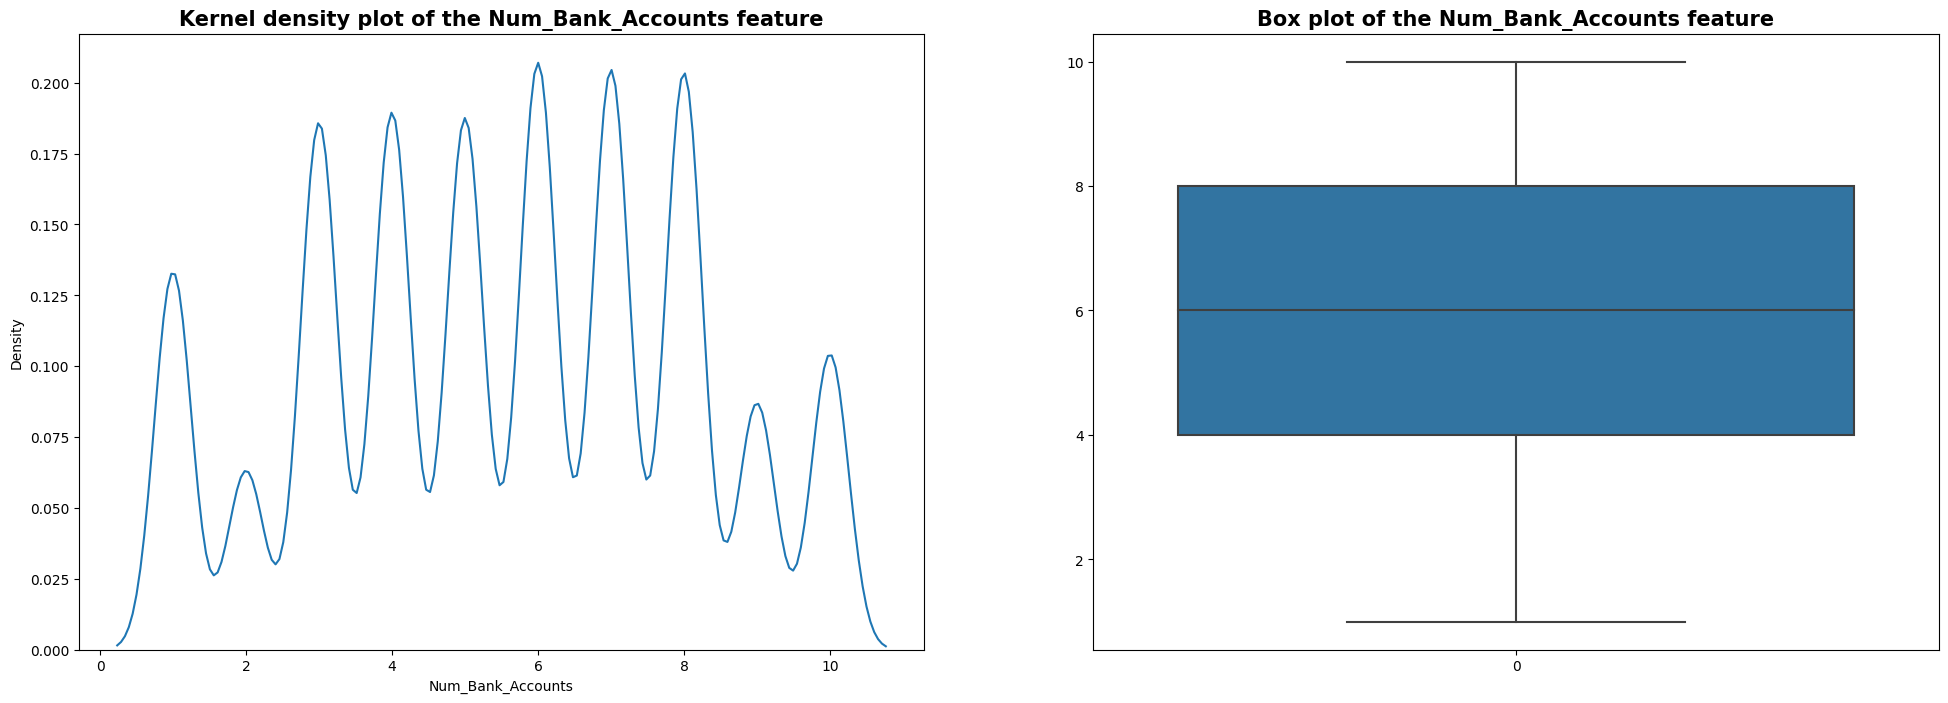

In [37]:
plot_feature(df['Num_Bank_Accounts'])

**6. Num credit cards**

In [38]:
df['Num_Credit_Card'].describe()

count    97217.000000
mean        22.489143
std        129.031469
min          0.000000
25%          4.000000
50%          6.000000
75%          7.000000
max       1499.000000
Name: Num_Credit_Card, dtype: float64

we have at least one instance where the num of credit card is 1,499, so we need to address that

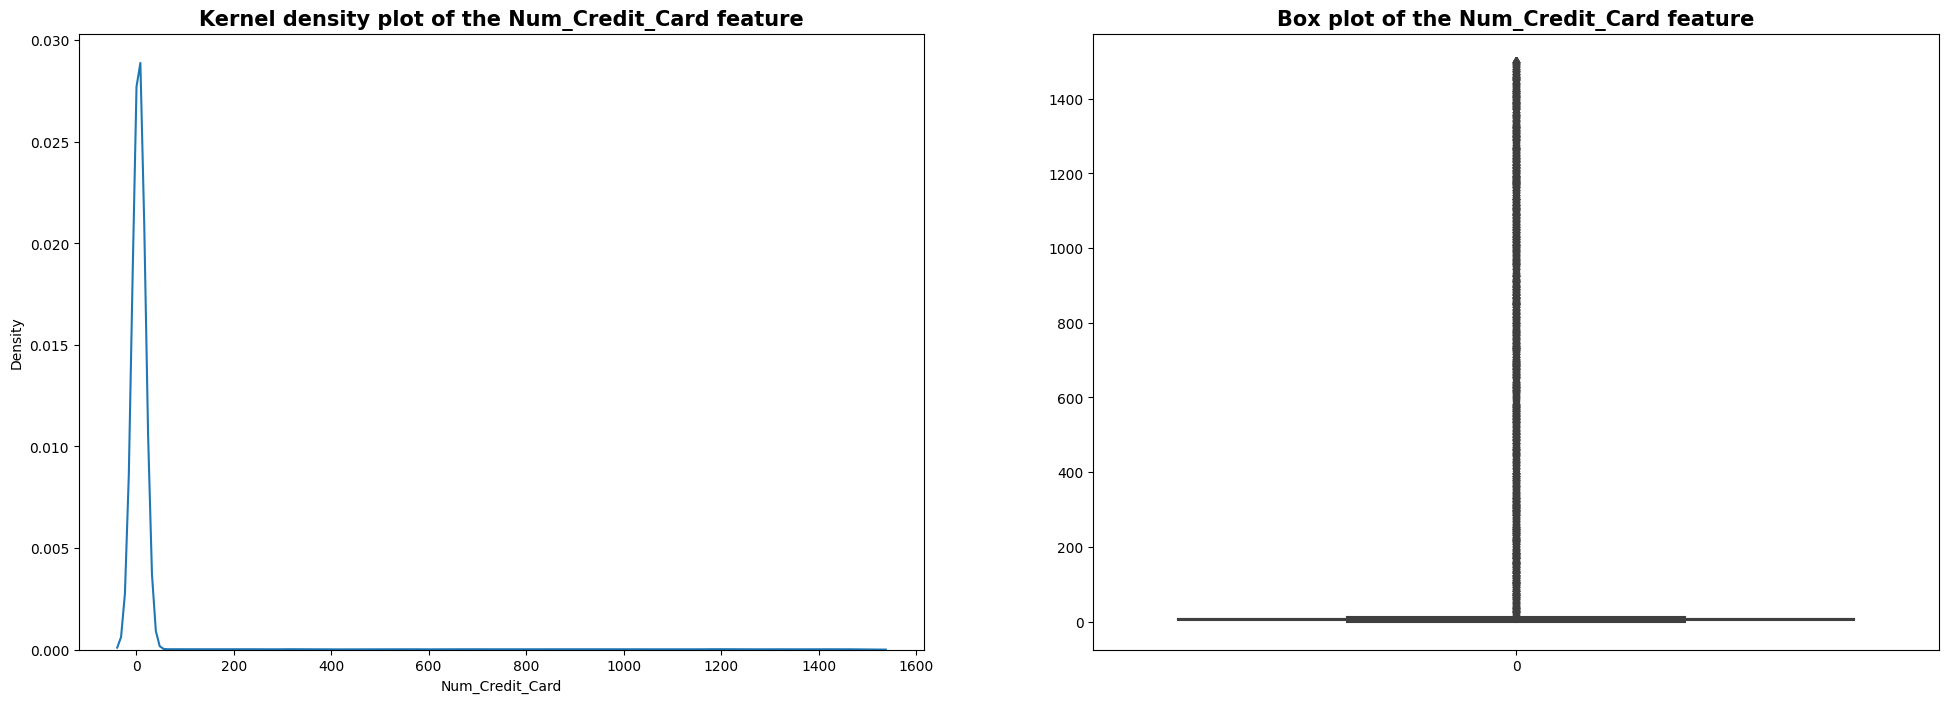

In [39]:
plot_feature(df['Num_Credit_Card'])

Again, we will clip our data rather deleting instances

In [40]:
# clipping values above 10 to 10

def clip_credit_card(feature):
    feature = np.where(feature.between(10,6000), 10, feature)
    return feature

In [41]:
df['Num_Credit_Card'] = clip_credit_card(df['Num_Credit_Card'])

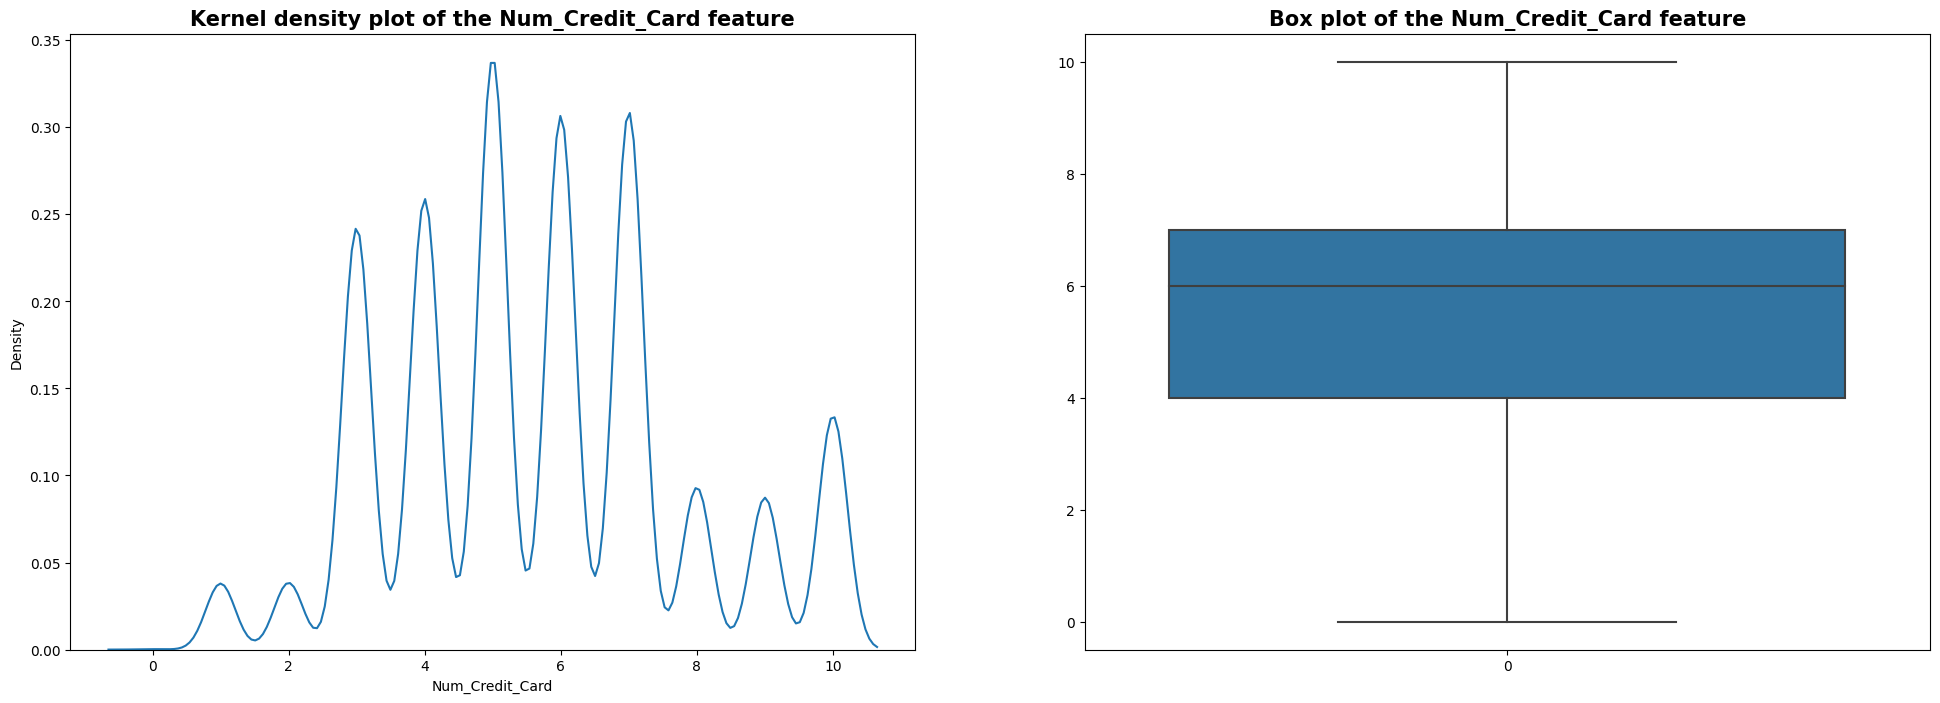

In [42]:
# Visualizing our feature

plot_feature(df['Num_Credit_Card'])

**7. Interest Rate**

In [43]:
# Checking our insterest rate

df['Interest_Rate'].describe()

count    97217.000000
mean        73.203822
std        469.411129
min          1.000000
25%          8.000000
50%         14.000000
75%         20.000000
max       5797.000000
Name: Interest_Rate, dtype: float64

In [44]:
# how many Interest rates have total instances more than 10?

df['Interest_Rate'].value_counts()[df['Interest_Rate'].value_counts() > 10].sort_index()

Interest_Rate
1     2488
2     2300
3     2589
4     2459
5     4791
6     4524
7     4330
8     4803
9     4344
10    4318
11    4181
12    4342
13    2362
14    2201
15    3962
16    3698
17    3772
18    4071
19    3593
20    3885
21    1544
22    1703
23    1664
24    1668
25    1551
26    1476
27    1593
28    1602
29    1646
30    1670
31    1435
32    1728
33    1448
34    1490
Name: count, dtype: int64

In [45]:
# seems like most of our values are within the range of 1 - 35, so we'll clip values exceeding that range

df['Interest_Rate'] = np.where(df['Interest_Rate'].between(35,6000), 35, df['Interest_Rate'])

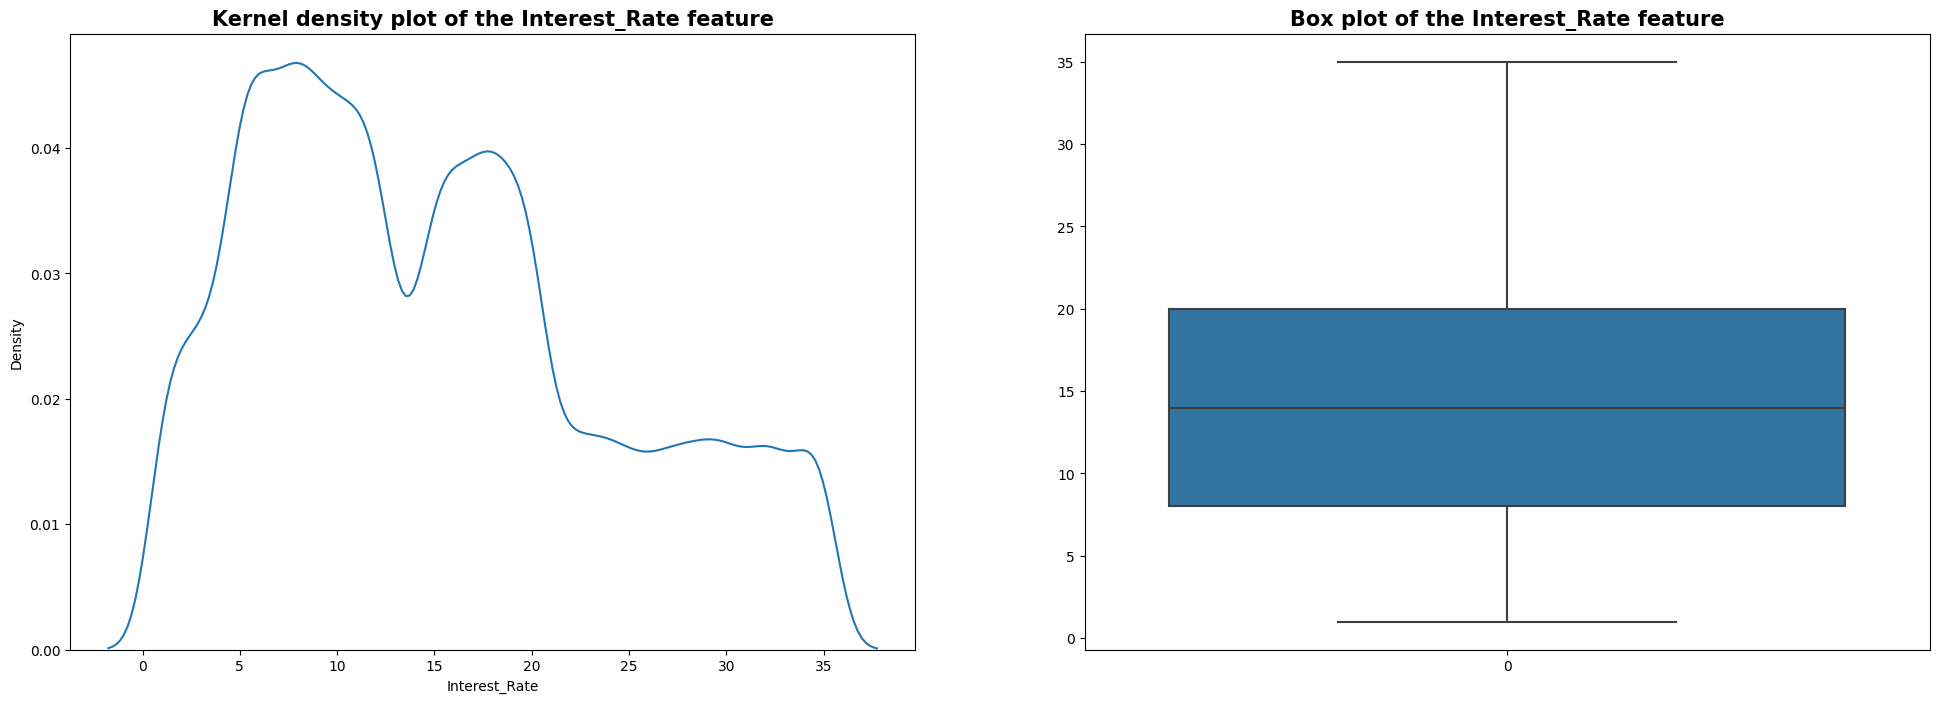

In [46]:
plot_feature(df['Interest_Rate'])

**8. Num of loan**

In [47]:
df['Num_of_Loan']

0        4
1        4
2        4
3        4
4        4
        ..
99995    2
99996    2
99997    2
99998    2
99999    2
Name: Num_of_Loan, Length: 97217, dtype: object

Our Num of loan feature is an object, so we need to clean it

In [48]:
# cleaning the feature

df['Num_of_Loan'] = df['Num_of_Loan'].map(lambda x: int(clean_feature(x)))

In [49]:
df['Num_of_Loan'].describe()

count    97217.000000
mean         3.038964
std         62.745324
min       -100.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1496.000000
Name: Num_of_Loan, dtype: float64

We will clip num of loans to values between 1 - 10

In [50]:
def clean_num_loan(feature):
    feature = np.where(feature.between(-200,0), 1, feature)
    feature = pd.Series(feature)
    feature = np.where(feature.between(10,2000), 10, feature)
    return feature

In [51]:
df['Num_of_Loan'] = clean_num_loan(df['Num_of_Loan'])

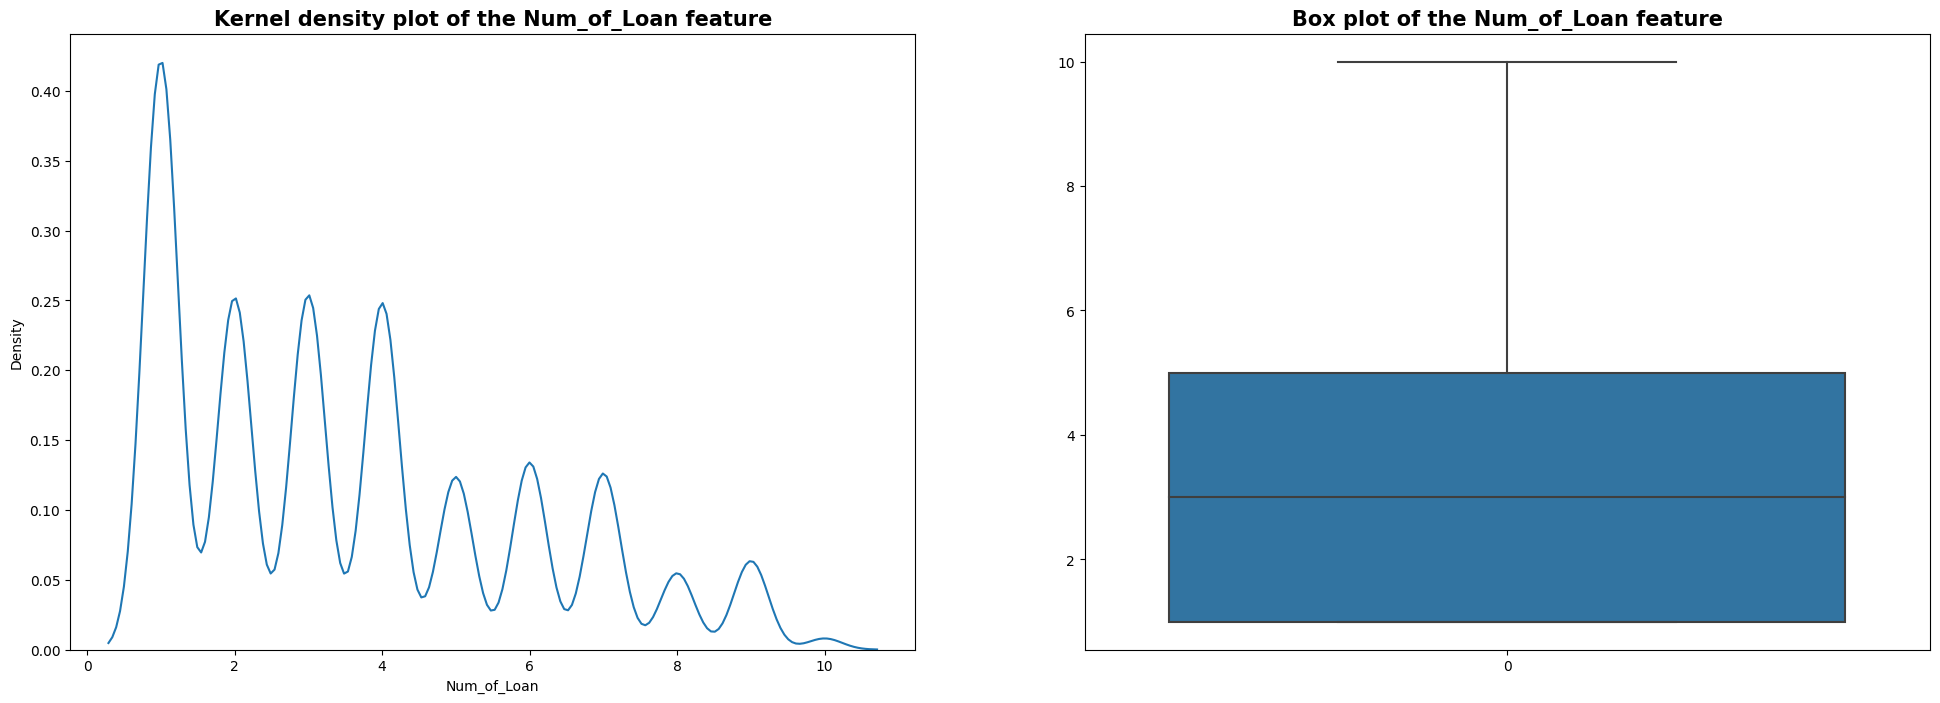

In [52]:
plot_feature(df['Num_of_Loan'])

**10. Delay from due date**

In [53]:
df['Delay_from_due_date'].describe()

count    97217.000000
mean        21.295051
std         14.882589
min         -5.000000
25%         10.000000
50%         18.000000
75%         28.000000
max         67.000000
Name: Delay_from_due_date, dtype: float64

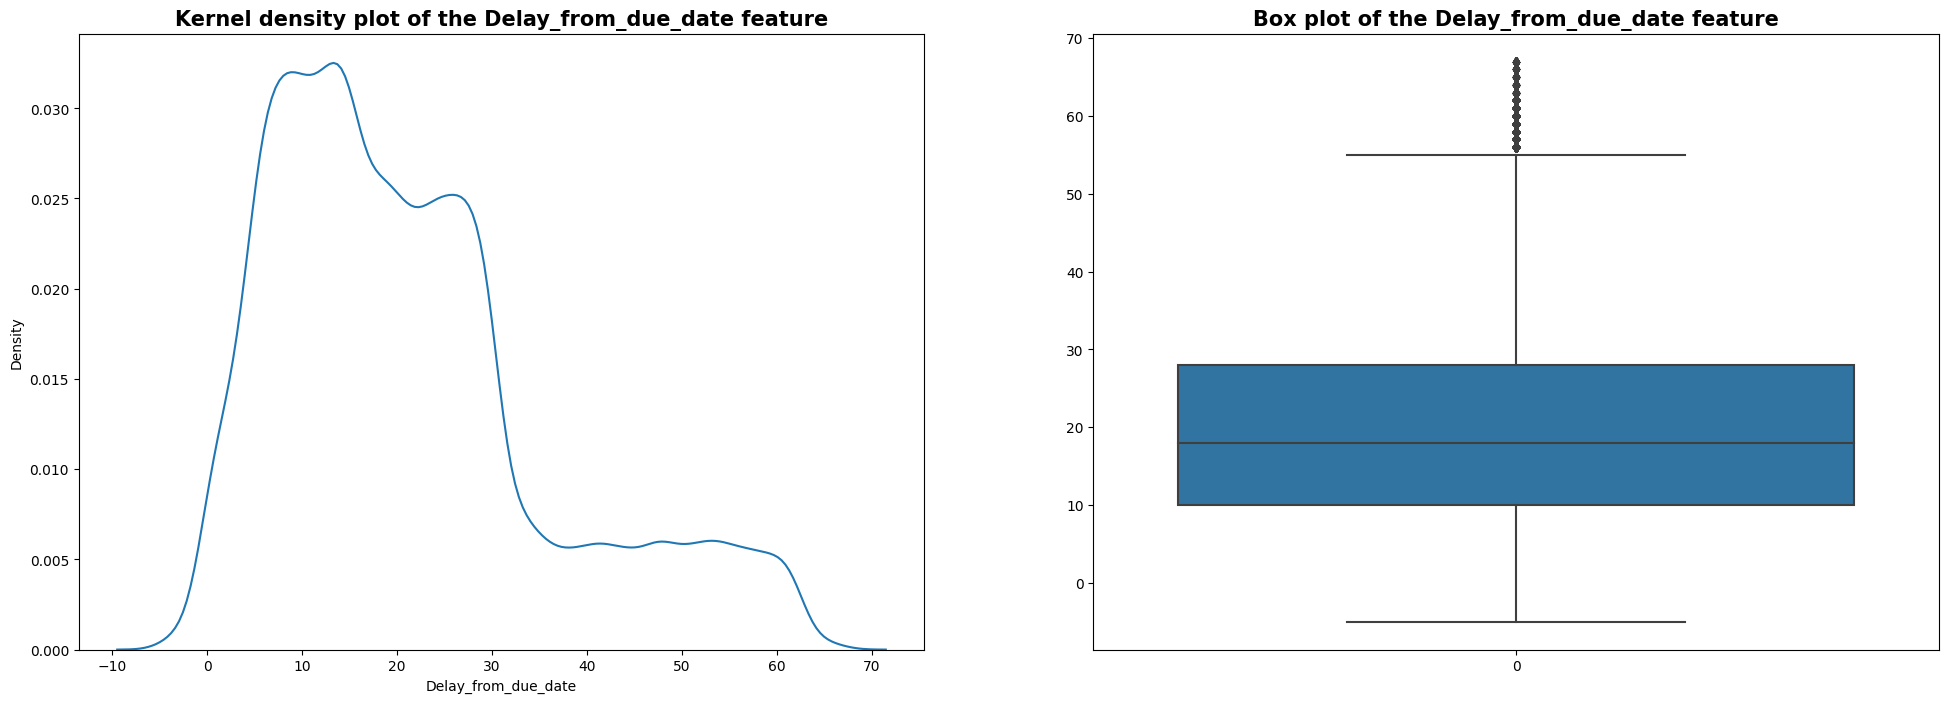

In [54]:
plot_feature(df['Delay_from_due_date'])

we don't have much outliers, however we'll clip values 

In [55]:
# any value less than 0 is set to 0

df['Delay_from_due_date'] = np.where(df['Delay_from_due_date'] < 0, 0, df['Delay_from_due_date'])

**11. Num of Delayed Payment**

In [56]:
# checking for number of null instances 

df['Num_of_Delayed_Payment'].isna().sum()

6803

In [57]:
# first we'll clean the values

df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].map(lambda x: clean_feature(x))

In [58]:
df['Num_of_Delayed_Payment'].describe()

count    90414.000000
mean        30.972548
std        225.398199
min         -3.000000
25%          9.000000
50%         14.000000
75%         18.000000
max       4397.000000
Name: Num_of_Delayed_Payment, dtype: float64

In [59]:
# checking for lowest value excluding values less than 0

df[~df['Num_of_Delayed_Payment'].between(-6,0)]['Num_of_Delayed_Payment'].min()

1.0

In [60]:
# checking for length of values above 30

df[df['Num_of_Delayed_Payment'] > 30]['Num_of_Delayed_Payment']

252      3318.0
284      3083.0
304      1338.0
409      3104.0
643       183.0
          ...  
99133    3336.0
99402    3392.0
99562    3688.0
99563     221.0
99825    2047.0
Name: Num_of_Delayed_Payment, Length: 712, dtype: float64

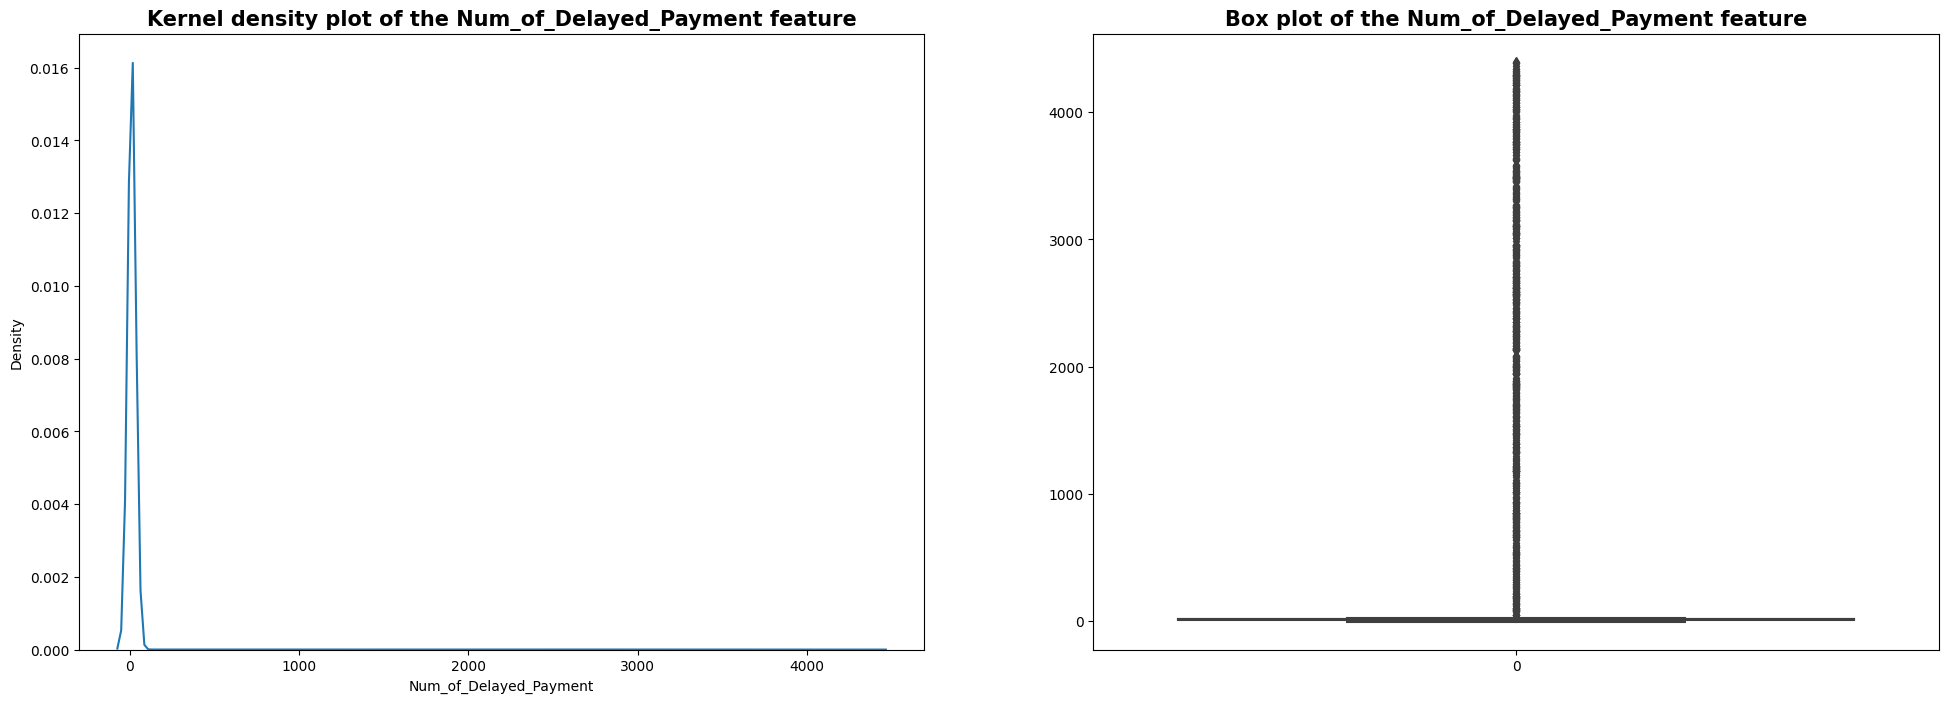

In [61]:
plot_feature(df['Num_of_Delayed_Payment'])

In [62]:
def clean_num_delay(feature):
    feature = np.where(feature.between(-5,0), 1, feature)
    feature = pd.Series(feature)
    feature = np.where(feature.between(30,4500), 30, feature)
    return feature

In [63]:
df['Num_of_Delayed_Payment'] = clean_num_delay(df['Num_of_Delayed_Payment'])

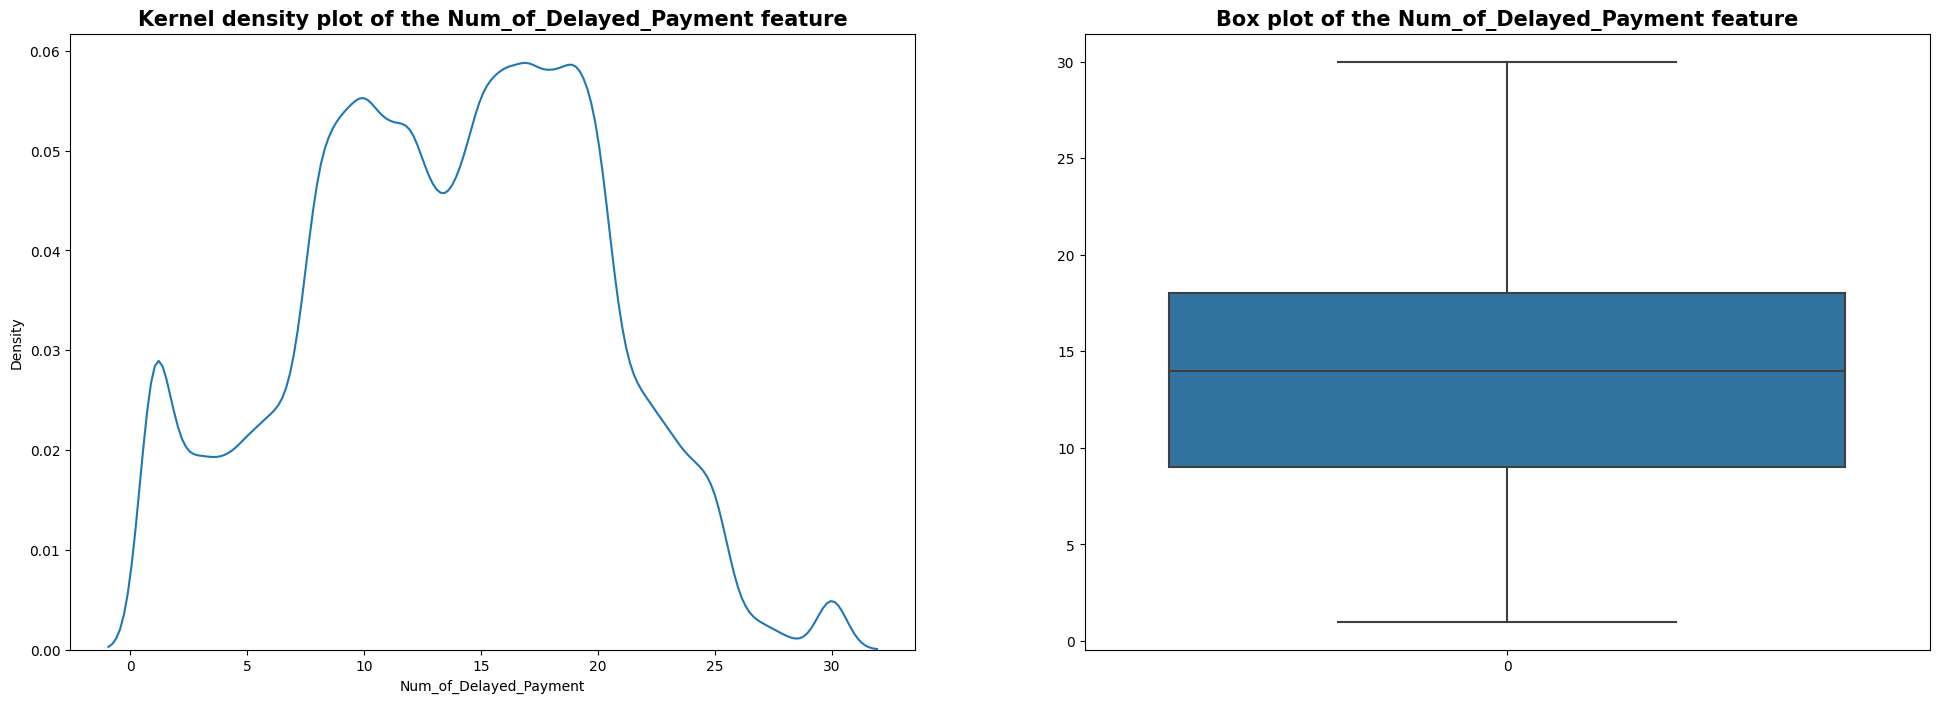

In [64]:
plot_feature(df['Num_of_Delayed_Payment'])

We still have missing values we need to fill. We will use the median to fill the missing values

In [65]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].fillna(df['Num_of_Delayed_Payment'].median())

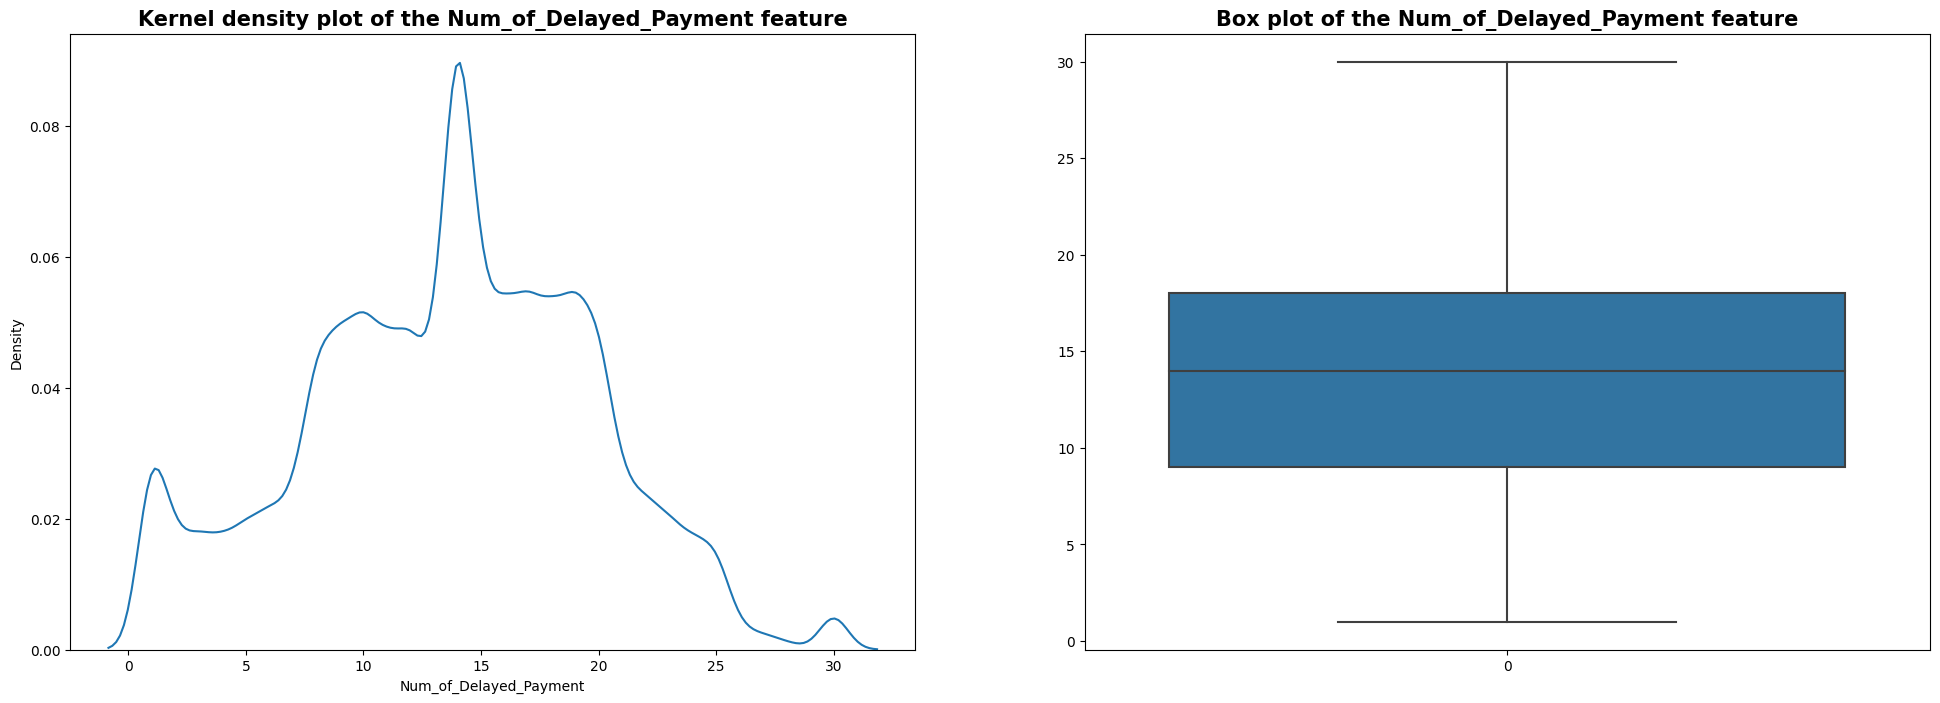

In [66]:
plot_feature(df['Num_of_Delayed_Payment'])

**12. Changed Credit Limit**

In [67]:
# checking the dtype

df['Changed_Credit_Limit']

0        11.27
1        11.27
2            _
3         6.27
4        11.27
         ...  
99995     11.5
99996     11.5
99997     11.5
99998     11.5
99999     11.5
Name: Changed_Credit_Limit, Length: 97217, dtype: object

`_` were used to denote instances where there were no credit limit change so we need to replaced them with 0

In [68]:
def clean_credit_limit(value):
    try:
        value = float(value)
    except ValueError:
        value = value.strip('_')
        value = 0
        value = float(value)
    return value

In [69]:
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].map(lambda x: clean_credit_limit(x))

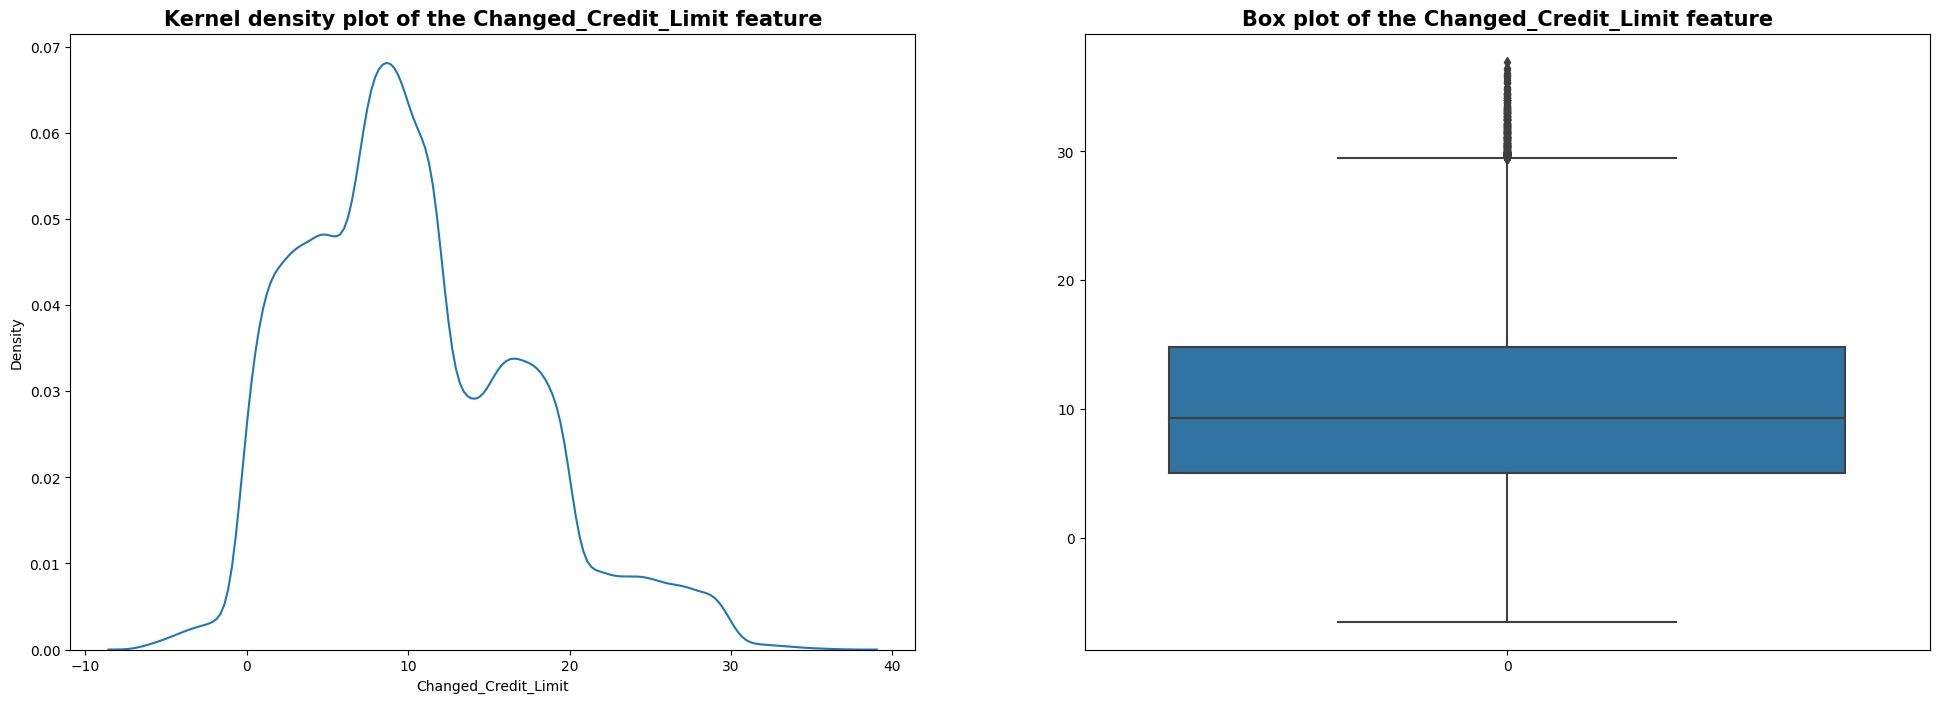

In [70]:
plot_feature(df['Changed_Credit_Limit'])

**13. Num Credit Inquiries**

In [71]:
# checking the descriptionm of our data

df['Num_Credit_Inquiries'].describe()

count    95304.000000
mean        27.785843
std        193.207603
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max       2597.000000
Name: Num_Credit_Inquiries, dtype: float64

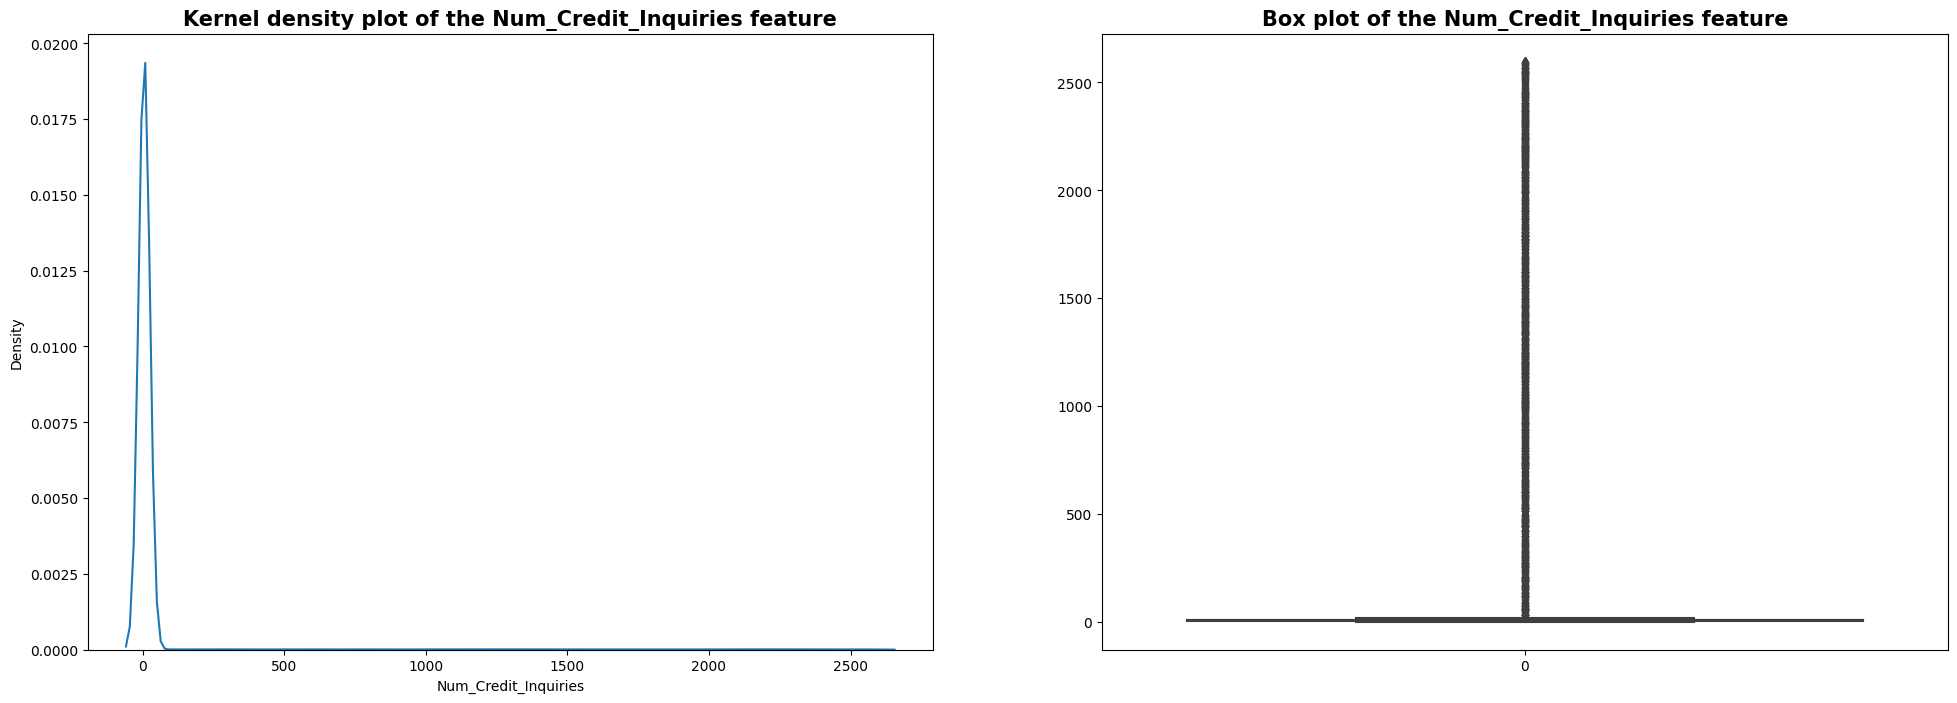

In [72]:
plot_feature(df['Num_Credit_Inquiries'])

we have a lot of ouliers, but rather than dropping the outliers, we will clip our values to 0 - 20 based on the 75% in the dataset description

In [73]:
def clip_credit_inquiries(feature):
    feature = np.where(feature > 20, 20, feature)
    return feature

In [74]:
# applying the function

df['Num_Credit_Inquiries'] = clip_credit_inquiries(df['Num_Credit_Inquiries'])

In [75]:
# we have some missing values we need to fill

df['Num_Credit_Inquiries'].fillna(df['Num_Credit_Inquiries'].median(), inplace=True)

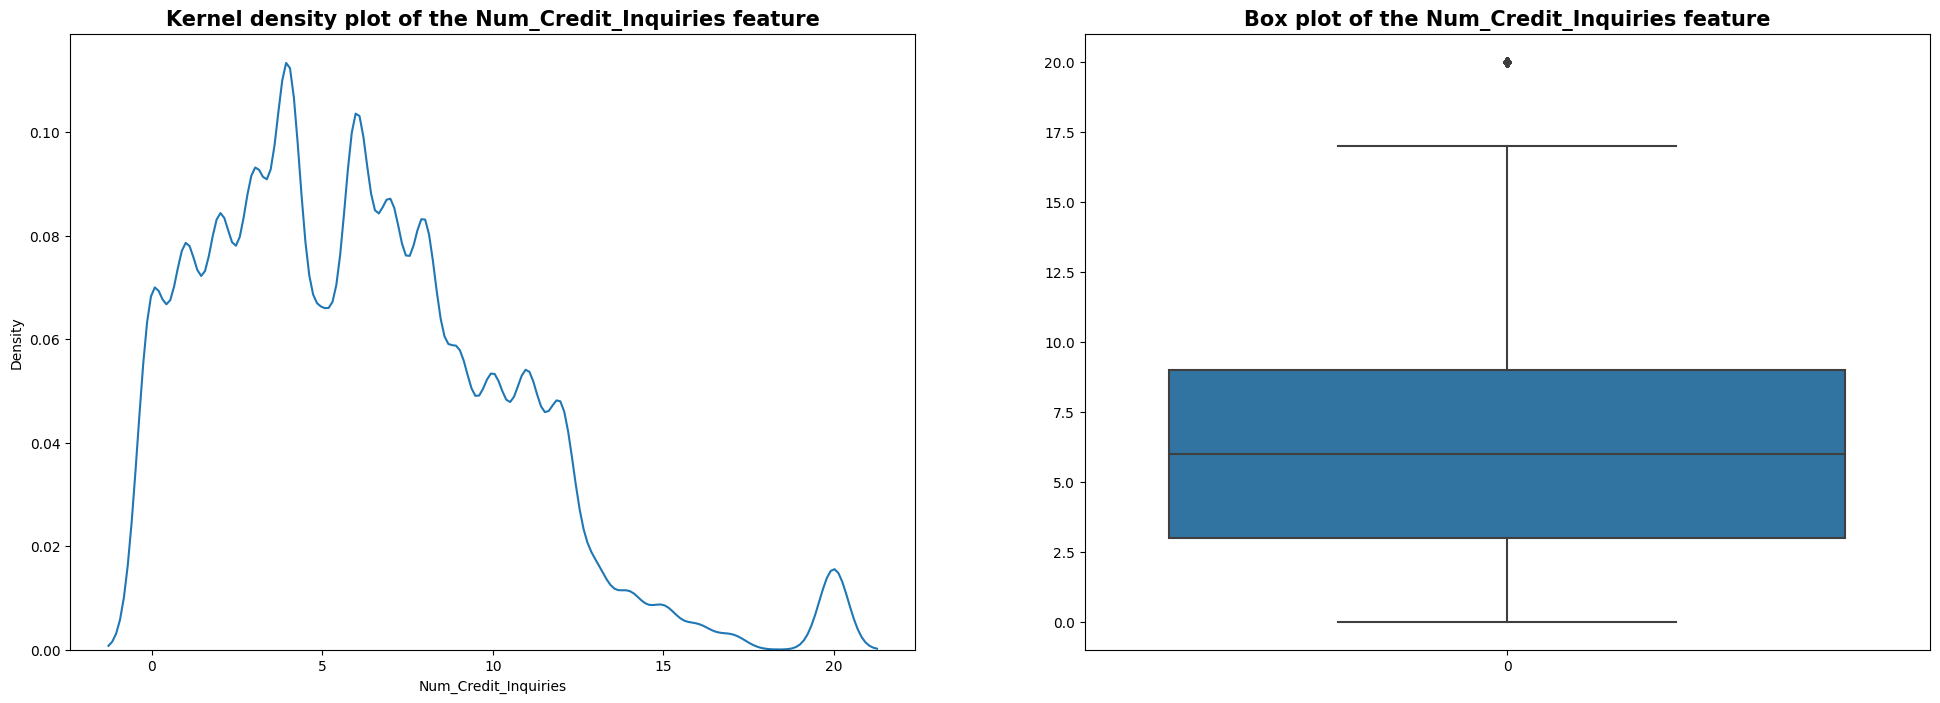

In [76]:
plot_feature(df['Num_Credit_Inquiries'])

**14. Credit Mix**

In [77]:
df['Credit_Mix'].value_counts(normalize=True)

Credit_Mix
Standard    0.371879
Good        0.233097
_           0.202022
Bad         0.193001
Name: proportion, dtype: float64

We have quite a number of instances that have no value for credit mix, rather than replacing these values with the mode, we will create a new category.

In [78]:
df['Credit_Mix'].head()

0       _
1    Good
2    Good
3    Good
4    Good
Name: Credit_Mix, dtype: object

In [79]:
# replacing instances with 'Not Specified'

df['Credit_Mix'].replace('_', 'Not Specified', inplace=True)
df['Credit_Mix'].head()

0    Not Specified
1             Good
2             Good
3             Good
4             Good
Name: Credit_Mix, dtype: object

**15. Outstanding Debt**

In [80]:
df['Outstanding_Debt']

0        809.98
1        809.98
2        809.98
3        809.98
4        809.98
          ...  
99995    502.38
99996    502.38
99997    502.38
99998    502.38
99999    502.38
Name: Outstanding_Debt, Length: 97217, dtype: object

The Outstanding Debt feature is an object so we need to clean it

In [81]:
# cleaning the feature

df['Outstanding_Debt'] = df['Outstanding_Debt'].map(lambda x: clean_feature(x))

In [82]:
df['Outstanding_Debt'].describe()

count    97217.000000
mean      1438.764109
std       1159.729009
min          0.230000
25%        573.650000
50%       1177.470000
75%       1971.680000
max       4998.070000
Name: Outstanding_Debt, dtype: float64

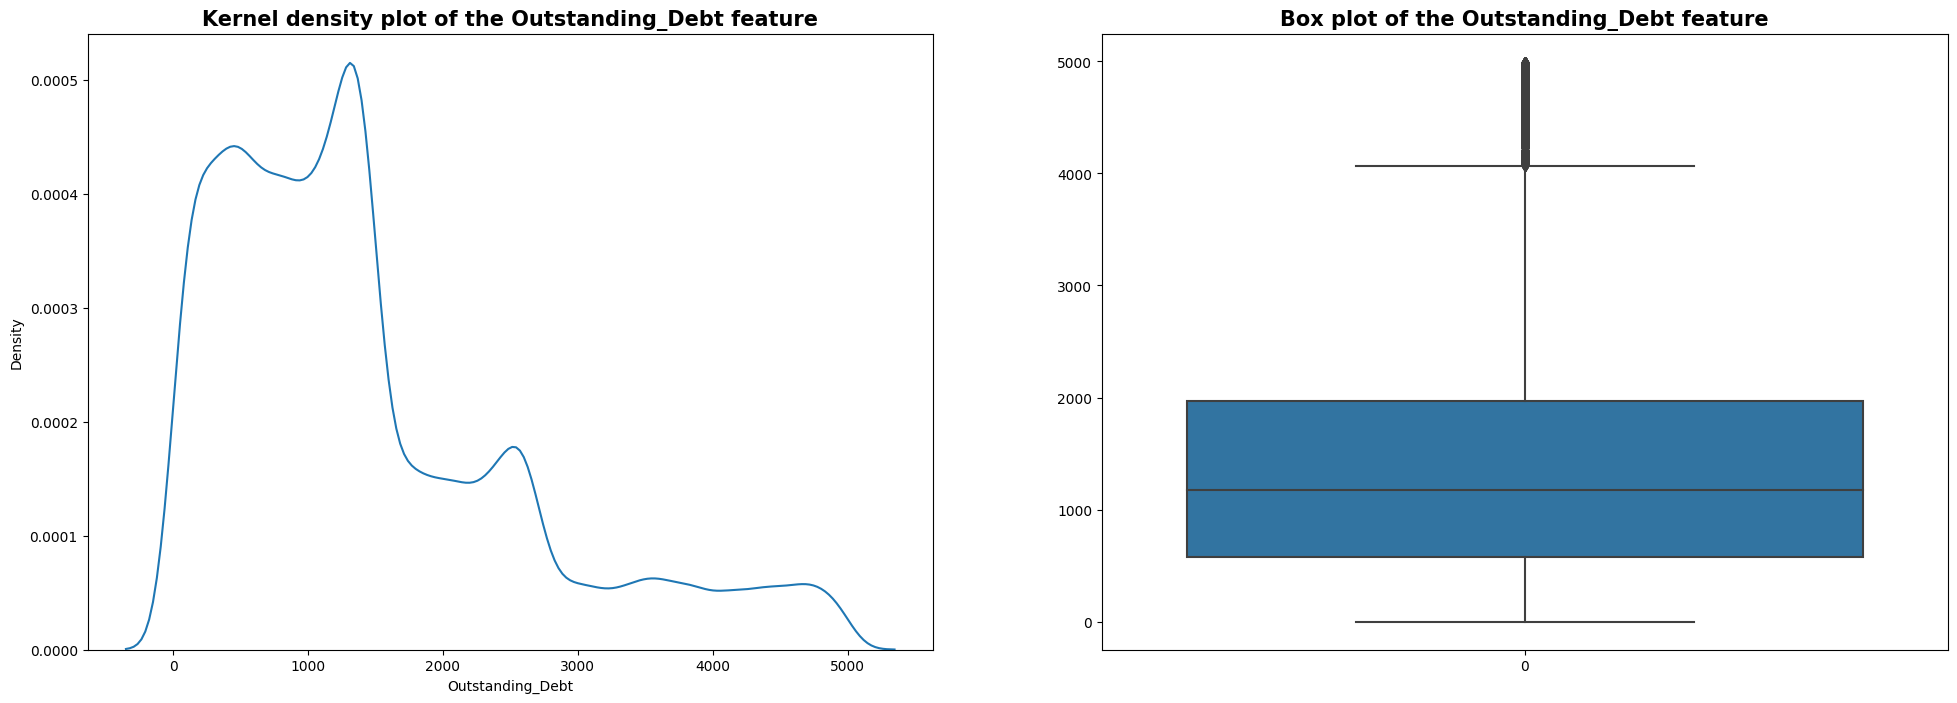

In [83]:
plot_feature(df['Outstanding_Debt'])

We could clip the values, leave them as is, or drop the outliers. We wil drop the outliers in this case as they are few. Either option is fine and only improves model performance

In [84]:
df = process_outliers(df['Outstanding_Debt'])

**16. Credit Utilization**

In [85]:
df['Credit_Utilization_Ratio'].describe()

count    92197.000000
mean        32.247626
std          5.085840
min         20.000000
25%         28.037738
50%         32.265294
75%         36.459982
max         48.337291
Name: Credit_Utilization_Ratio, dtype: float64

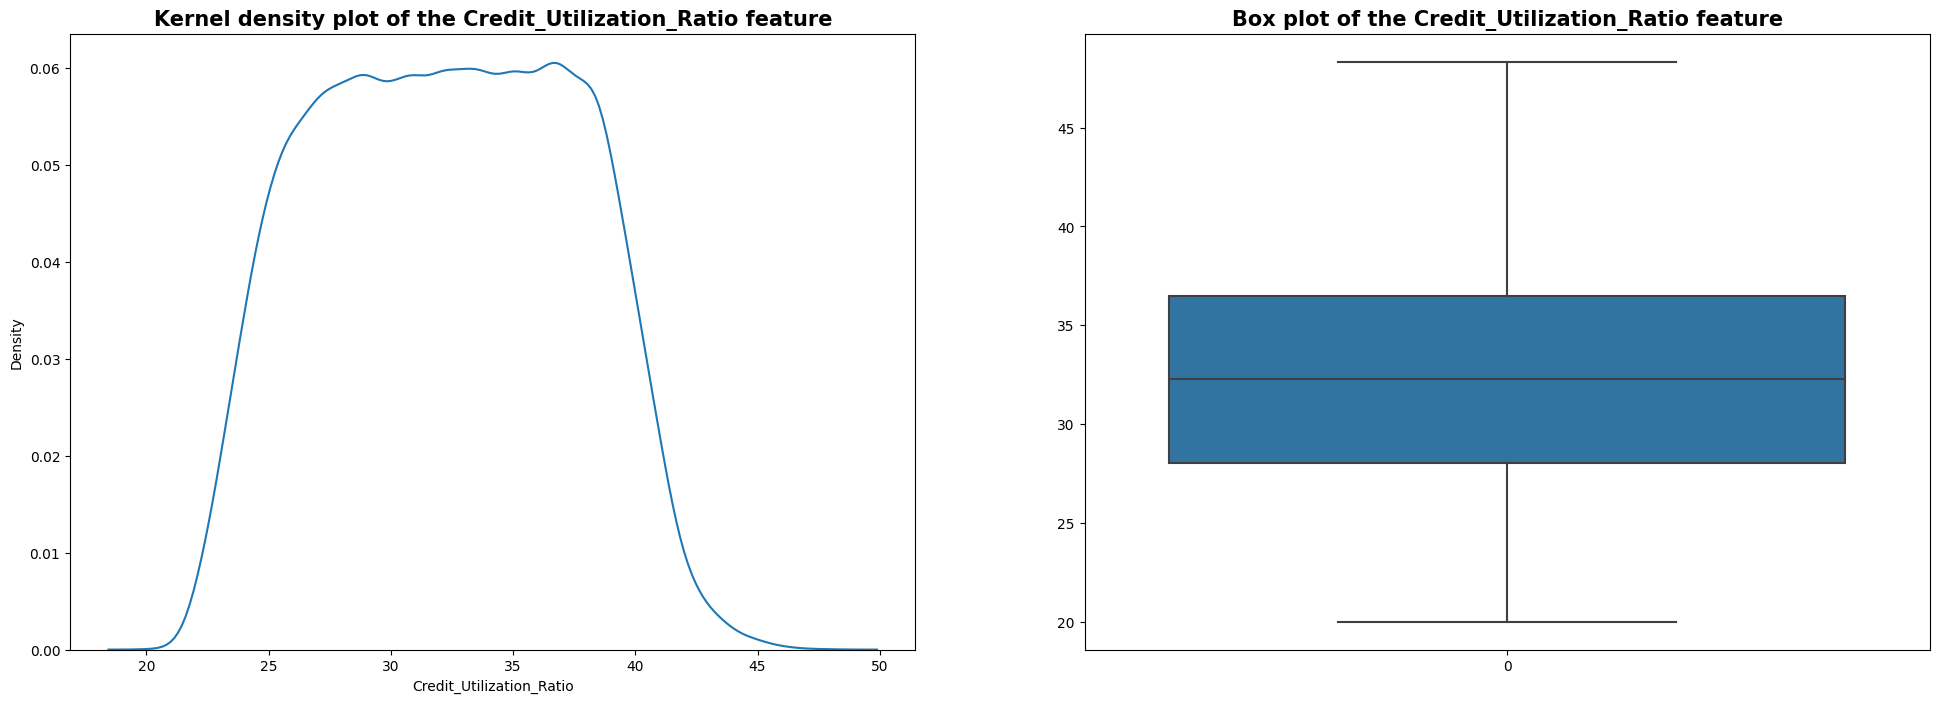

In [86]:
plot_feature(df['Credit_Utilization_Ratio'])

Credit utilization is clean so we don not need to preprocess it any further

**17. Credit History**

The Credit history age has years and month. We will only retrieve the years and create bins for them

In [87]:
# creating a helper function. We have some NaN values we'll fill later on but for now we need to use a try except block

def process_credit_history(value):
    try:
        value = int(value.split(' ')[0])
    except:
        pass
    return value

In [88]:
# applying function and filling missing values

df['Credit_History_Age'] = df['Credit_History_Age'].map(lambda x: process_credit_history(x))
df['Credit_History_Age'].fillna(df['Credit_History_Age'].median(), inplace=True)

In [89]:
# checking value counts

df['Credit_History_Age'].value_counts()

Credit_History_Age
18.0    12951
19.0     4656
17.0     4558
16.0     4368
15.0     3760
20.0     3210
30.0     2800
32.0     2769
6.0      2698
31.0     2696
23.0     2688
24.0     2680
29.0     2662
13.0     2632
28.0     2631
22.0     2621
26.0     2621
21.0     2610
27.0     2547
8.0      2487
11.0     2441
12.0     2430
9.0      2412
25.0     2400
7.0      2278
10.0     2257
14.0     2191
5.0      1662
33.0     1068
1.0       597
2.0       572
4.0       485
3.0       451
0.0       308
Name: count, dtype: int64

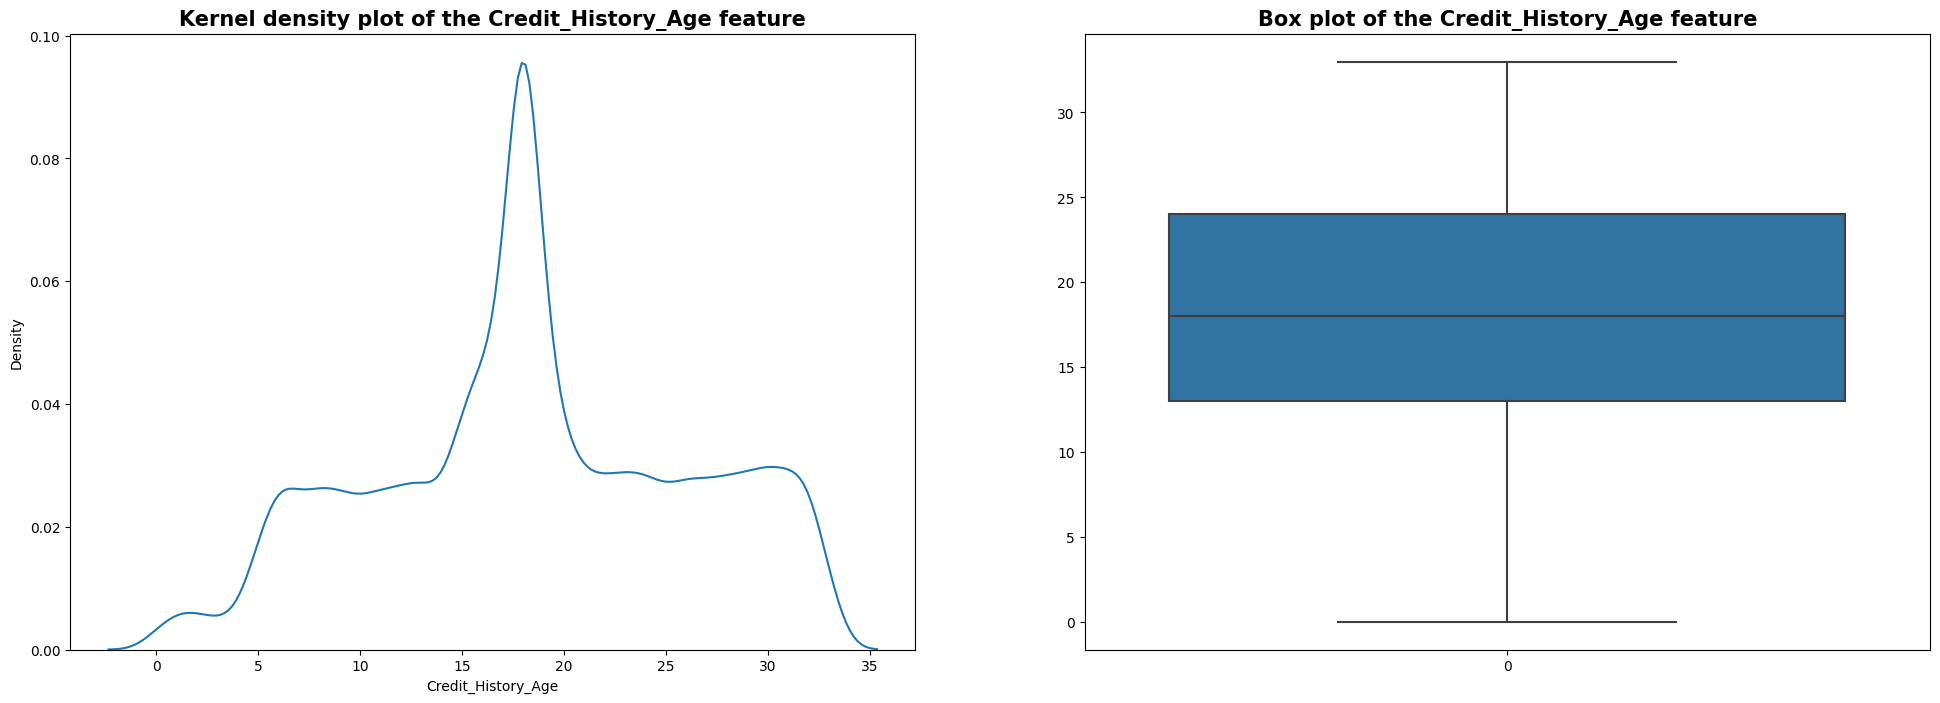

In [90]:
plot_feature(df['Credit_History_Age'])

In [91]:
# creating classes for our credit history age

df['Credit_History_labels'] = pd.cut(df['Credit_History_Age'], bins=[float('-inf'), 5, 10, 25, 30, 35], labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

**17. Payment Min Amount**

In [92]:
# We have no issues here, so we'll move ahead

df['Payment_of_Min_Amount'].value_counts()

Payment_of_Min_Amount
Yes    47397
No     33750
NM     11050
Name: count, dtype: int64

**18. Total EMI**

In [93]:
# checking the description 

df['Total_EMI_per_month'].describe()

count    92197.000000
mean      1393.915616
std       8278.354531
min          0.000000
25%         28.643889
50%         66.378963
75%        152.888016
max      82331.000000
Name: Total_EMI_per_month, dtype: float64

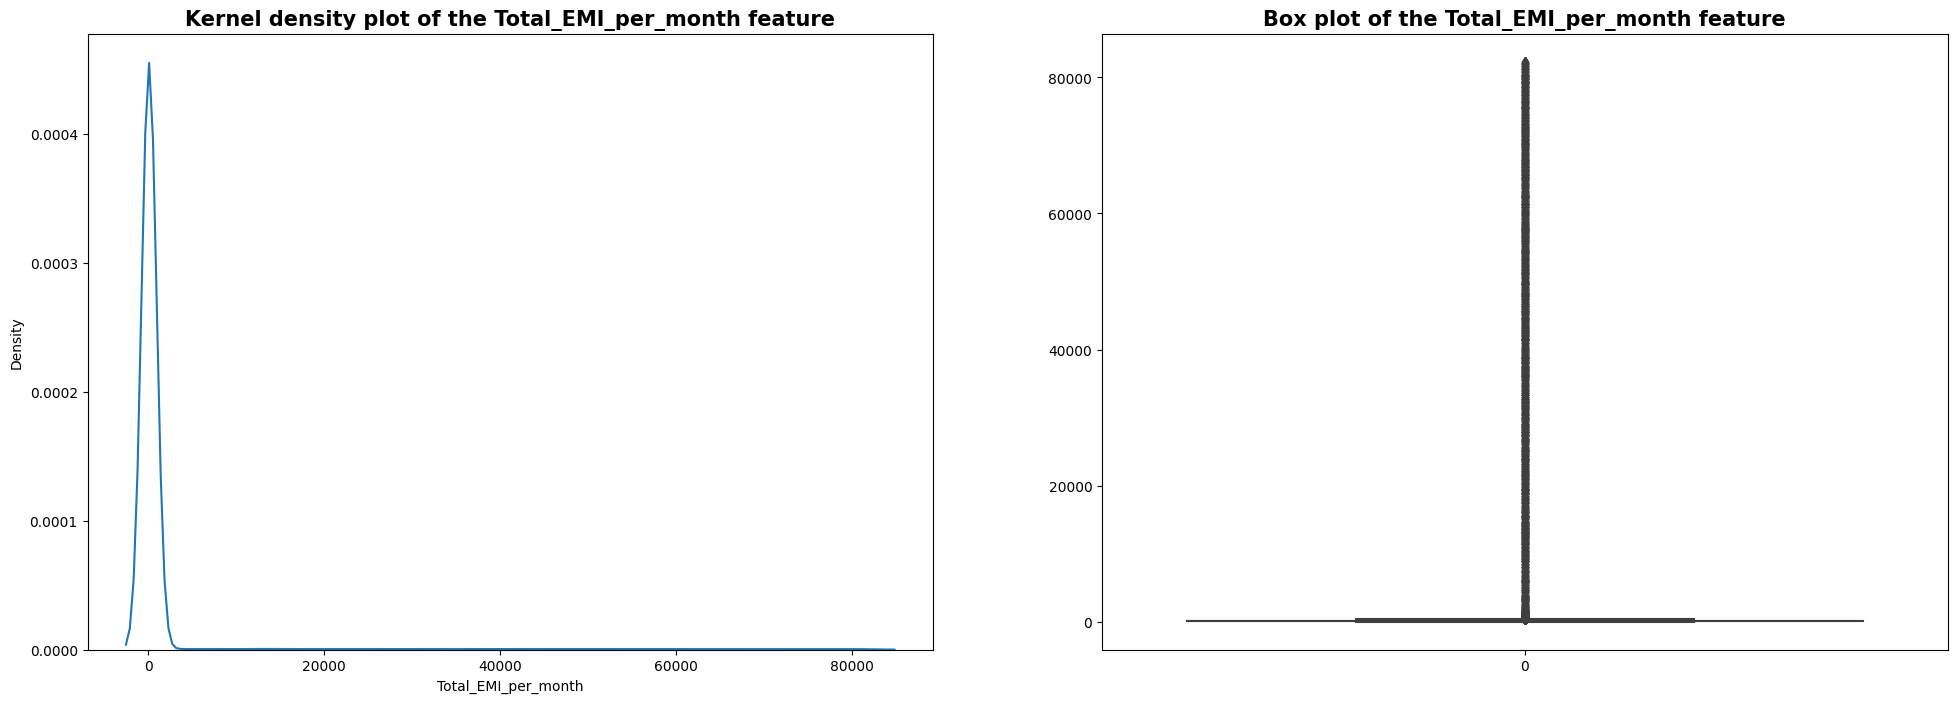

In [94]:
plot_feature(df['Total_EMI_per_month'])

In [95]:
# we'll drop the outliers

df = process_outliers(df['Total_EMI_per_month'])

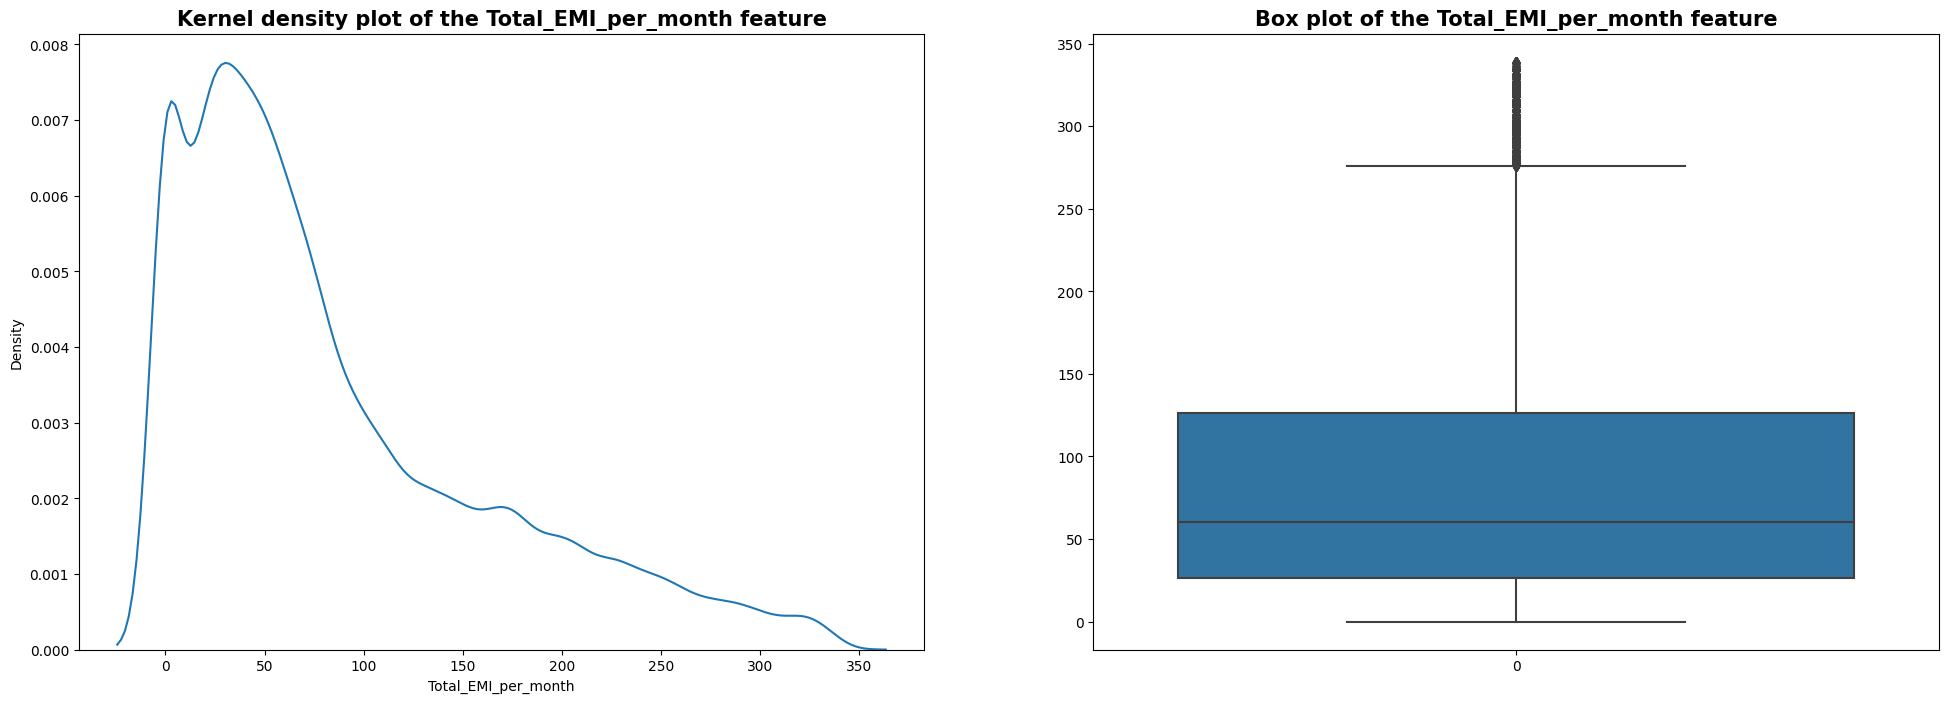

In [96]:
plot_feature(df['Total_EMI_per_month'])

**18. Amount invested monthly**

In [97]:
# cleaning our feature

df['Amount_invested_monthly'] = df['Amount_invested_monthly'].map(lambda x: clean_feature(x))

In [98]:
# checking the description

df['Amount_invested_monthly'].describe()

count    81972.000000
mean       627.481168
std       2042.718947
min          0.000000
25%         73.263523
50%        132.241956
75%        252.814378
max      10000.000000
Name: Amount_invested_monthly, dtype: float64

In [99]:
df['Amount_invested_monthly'].isna().sum()

3843

In [100]:
# we have close to 4,000 missing values we need to replace with the features's median value

df['Amount_invested_monthly'].fillna(df['Amount_invested_monthly'].median(), inplace=True)

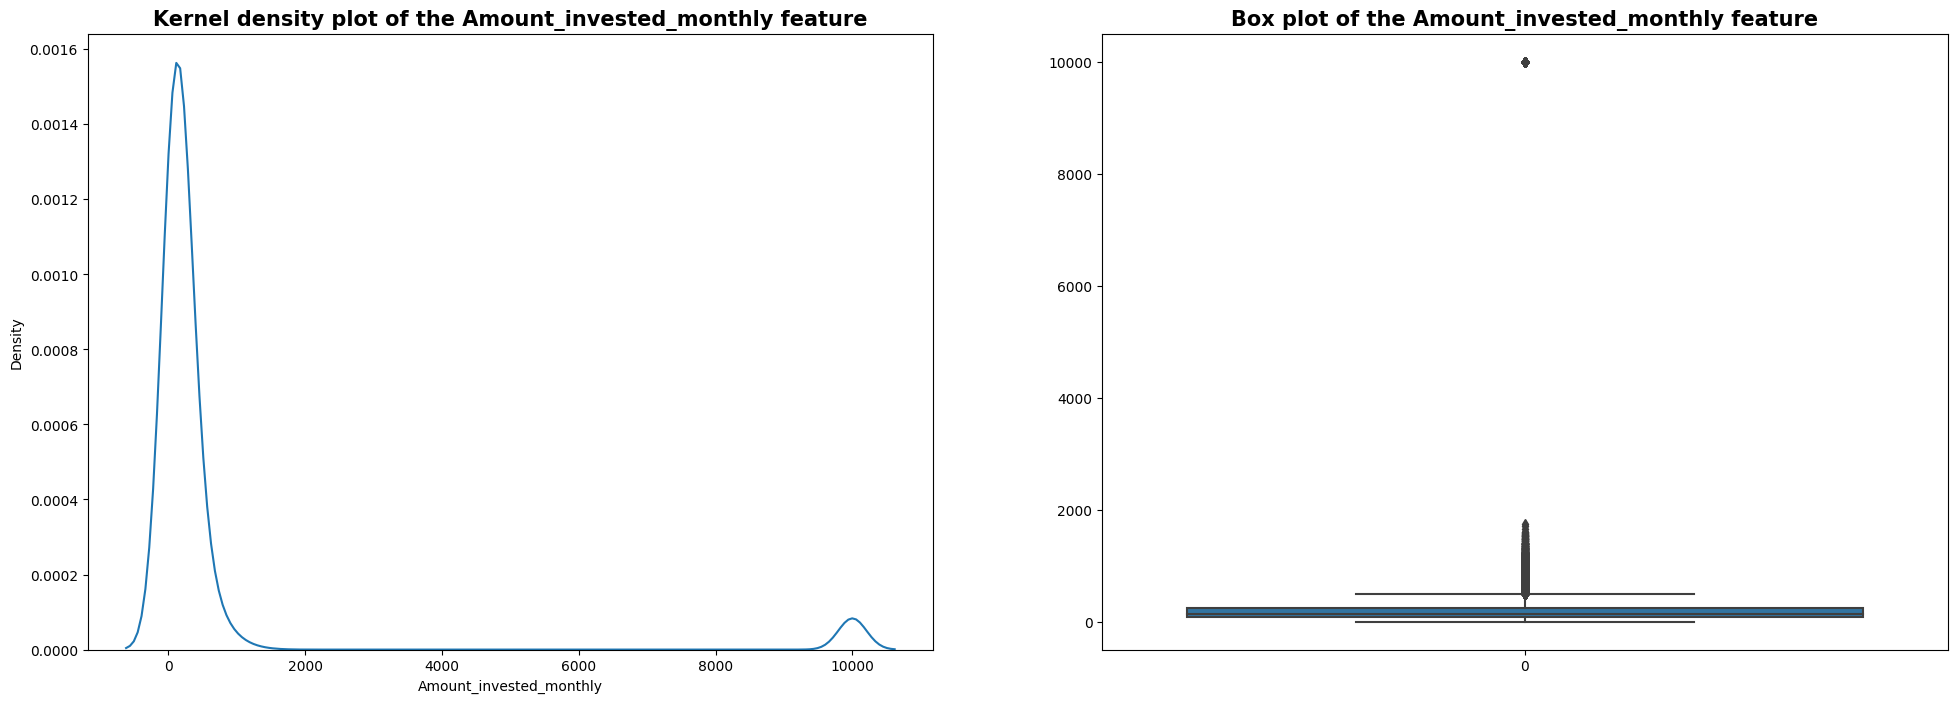

In [101]:
plot_feature(df['Amount_invested_monthly'])

From the plots above we can see we have some extreme values. Rather than dropping them, we'll clip them.

In [102]:
# clipping values above 1000

df['Amount_invested_monthly'] = np.where(df['Amount_invested_monthly'] > 1000, 1000, df['Amount_invested_monthly'])

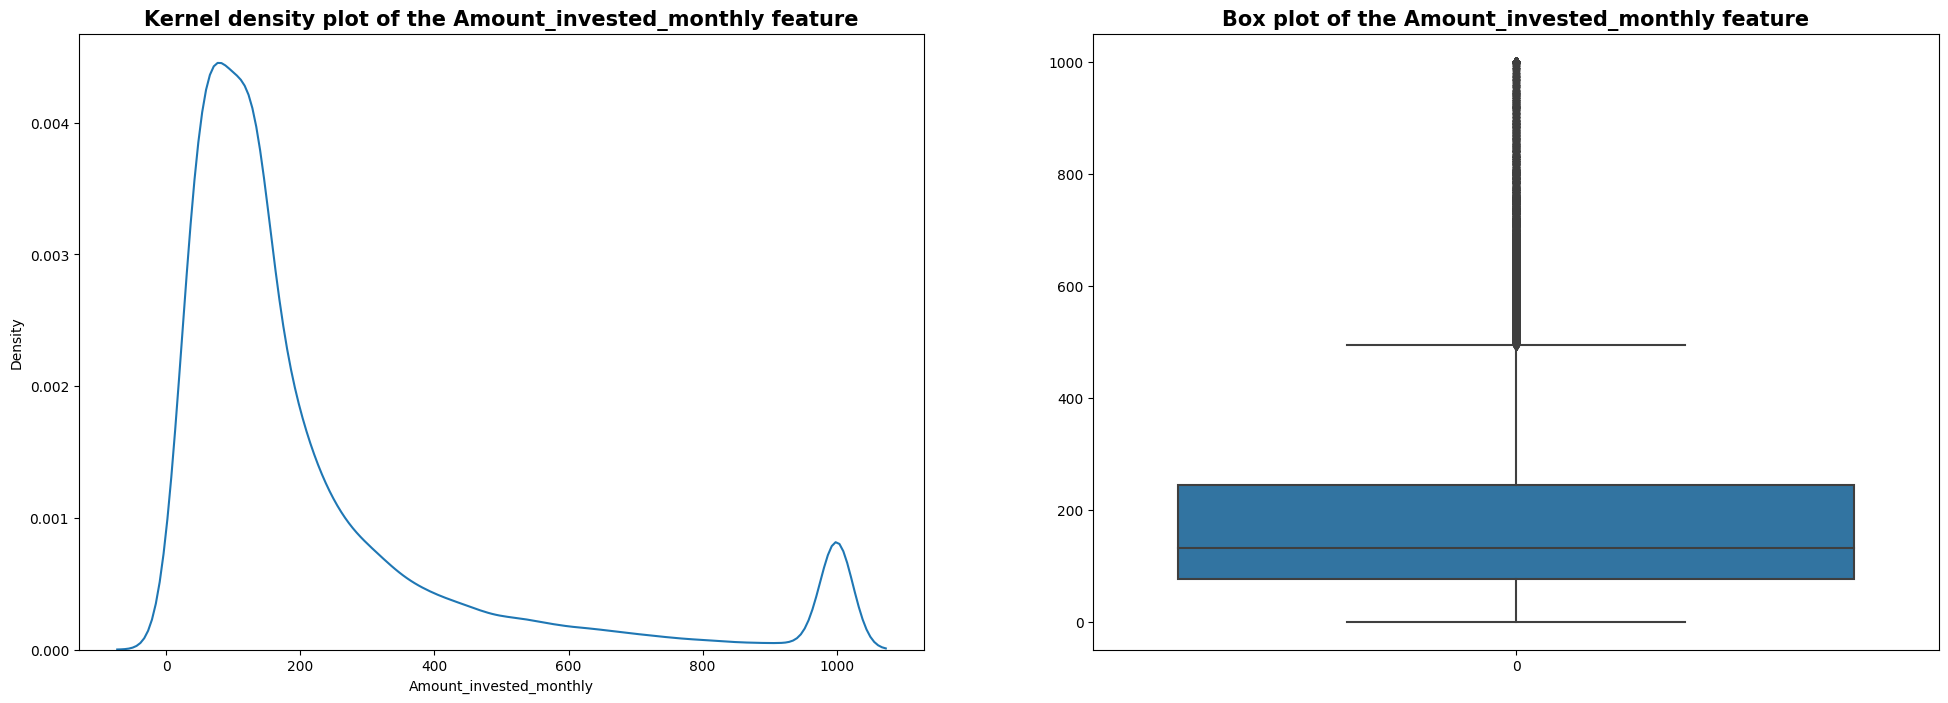

In [103]:
plot_feature(df['Amount_invested_monthly'])

**19. Payment Behaviour**

In [104]:
df['Payment_Behaviour'].value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      22382
High_spent_Medium_value_payments    15085
Low_spent_Medium_value_payments     11679
High_spent_Large_value_payments     11349
High_spent_Small_value_payments      9809
Low_spent_Large_value_payments       9018
!@9#%8                               6493
Name: count, dtype: int64

In [105]:
# we have a value we need to replace !@9#%8

df['Payment_Behaviour'].replace('!@9#%8', 'Not Specified', inplace=True)

**20. Monthly Balance**

In [106]:
# cleaning the feature

df['Monthly_Balance'] = df['Monthly_Balance'].map(lambda x: clean_feature(x))

In [107]:
# checking its description

df['Monthly_Balance'].describe()

count    8.513000e+04
mean    -2.740906e+22
std      3.022534e+24
min     -3.333333e+26
25%      2.732859e+02
50%      3.386281e+02
75%      4.667163e+02
max      1.415565e+03
Name: Monthly_Balance, dtype: float64

from the description above, we have some values less than 0.

In [108]:
# retrieving values less than 0

df[df['Monthly_Balance'] < 0]['Monthly_Balance']

5545    -3.333333e+26
26177   -3.333333e+26
29158   -3.333333e+26
38622   -3.333333e+26
60009   -3.333333e+26
75251   -3.333333e+26
83255   -3.333333e+26
Name: Monthly_Balance, dtype: float64

We have few values less than 0, and they look like mistakes, so we'll replace them with 0

In [109]:
# replacing values less than 0

df['Monthly_Balance'] = np.where(df['Monthly_Balance'] < 0, 0, df['Monthly_Balance'])

In [110]:
df['Monthly_Balance'].isna().sum()

685

In [111]:
# we have 685 missing values we will fill using the feature's median

df['Monthly_Balance'].fillna(df['Monthly_Balance'].median(), inplace=True)

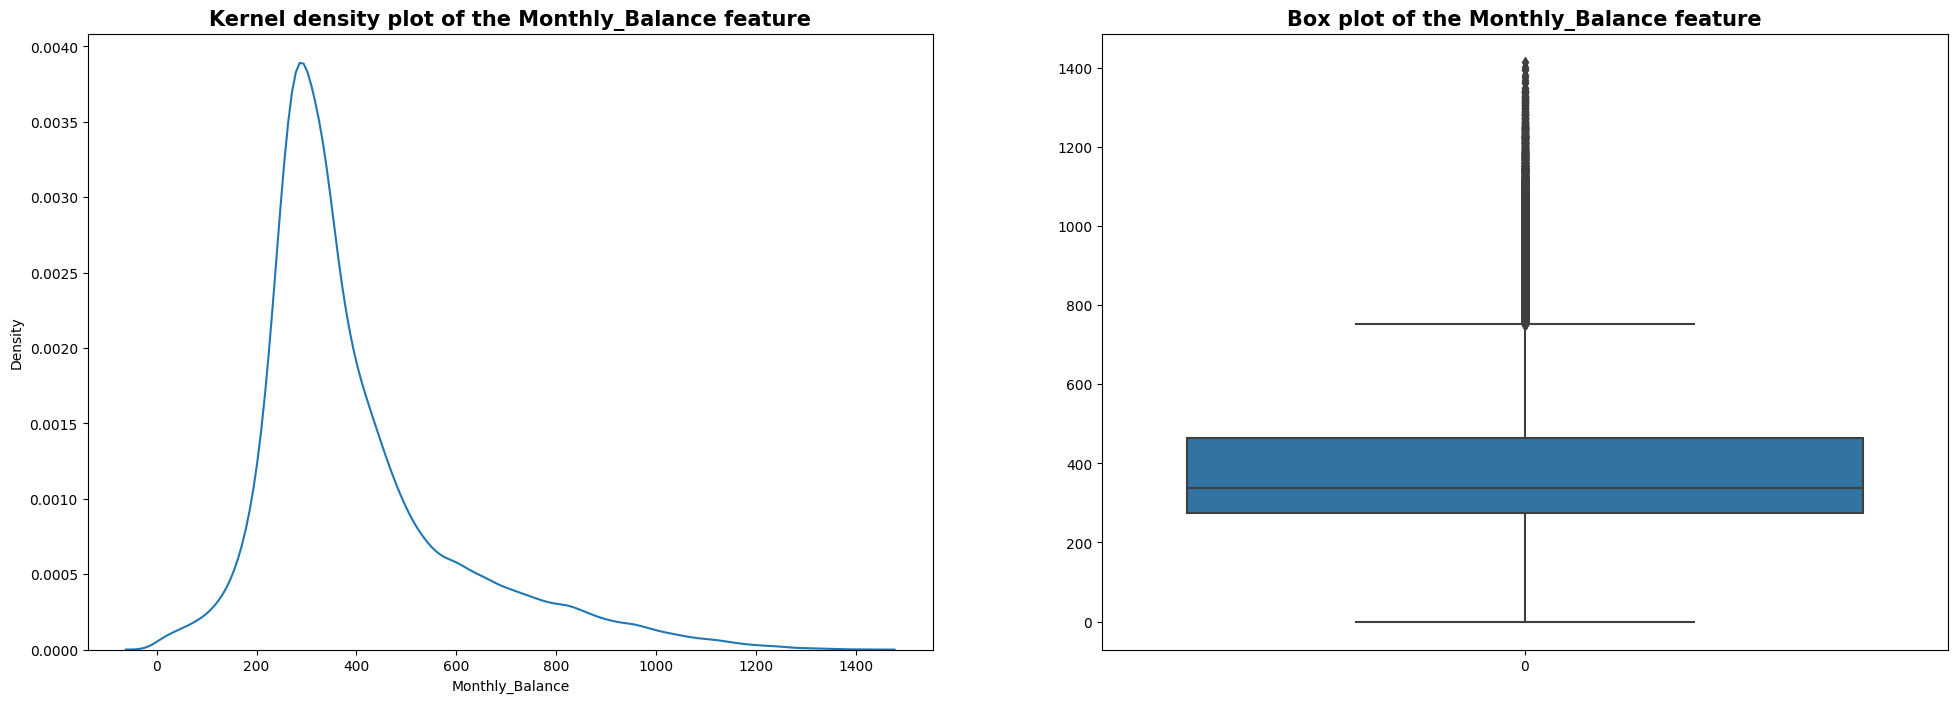

In [112]:
plot_feature(df['Monthly_Balance'])

**21. Credit Score**

In [113]:
df['Credit_Score'].value_counts()

Credit_Score
Standard    46237
Poor        24427
Good        15151
Name: count, dtype: int64

Our target, Credit score, looks fine so we'll proceed

**9. Type of Loan**

In [114]:
# we have dropped some instances along the way so we need to rest our index

df.reset_index(drop=True, inplace=True)

In [115]:
df['Type_of_Loan'].isna().sum()

10385

We have over 10,000 missing values. rather than dropping them, we will fill them using 'Not Specified'

In [116]:
# filling missing values

df['Type_of_Loan'].fillna('Not Specified', inplace=True)

In [117]:
df['Type_of_Loan']

0        Auto Loan, Credit-Builder Loan, Personal Loan,...
1        Auto Loan, Credit-Builder Loan, Personal Loan,...
2        Auto Loan, Credit-Builder Loan, Personal Loan,...
3        Auto Loan, Credit-Builder Loan, Personal Loan,...
4        Auto Loan, Credit-Builder Loan, Personal Loan,...
                               ...                        
85810                          Auto Loan, and Student Loan
85811                          Auto Loan, and Student Loan
85812                          Auto Loan, and Student Loan
85813                          Auto Loan, and Student Loan
85814                          Auto Loan, and Student Loan
Name: Type_of_Loan, Length: 85815, dtype: object

Our feature has various combinations of loan types, and we need to identify the unique loan types. To do that we need to first convert the instances to list

In [118]:
# splitting each instance and converting them to a list

loan_types_list = df['Type_of_Loan'].str.split(',').tolist()

In [119]:
loan_types_list[:2]

[['Auto Loan',
  ' Credit-Builder Loan',
  ' Personal Loan',
  ' and Home Equity Loan'],
 ['Auto Loan',
  ' Credit-Builder Loan',
  ' Personal Loan',
  ' and Home Equity Loan']]

We can see that we have 'and' in the last index of each instance that we need to remove otherwise they will count as a unique value

In [120]:
# removing the 'and' if its present 
loan_types_list = [[loan.replace(' and ', '') if 'and' in loan else loan for loan in loan_type] for loan_type in loan_types_list]

# removing the left space if present in all values
loan_types_list = [[loan.lstrip(' ') for loan in loan_type] for loan_type in loan_types_list]

In [121]:
# printing our unique values

loan_types_flattened = [loan_type.strip() for sublist in loan_types_list for loan_type in sublist]

vocab = np.unique(loan_types_flattened)

print(vocab)

['Auto Loan' 'Credit-Builder Loan' 'Debt Consolidation Loan'
 'Home Equity Loan' 'Mortgage Loan' 'Not Specified' 'Payday Loan'
 'Personal Loan' 'Student Loan']


looks right so we can proceed

In [122]:
# replacing the previous feature with our cleaned and processed loan types
df['Type_of_Loan'] = pd.Series(loan_types_list)

# each instance is a list, so we need to get rid of the list by joining its values
df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: ", ".join(x))

In [123]:
df['Type_of_Loan'].head()[0]

'Auto Loan, Credit-Builder Loan, Personal Loan, Home Equity Loan'

Nice!, we have been able to process the data appropriately

In [124]:
# creating dummies for each unique loan type

df = pd.concat((df, df['Type_of_Loan'].str.get_dummies(sep=', ')), axis=1)
df.head()

,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_History_labels,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,23,Scientist,19114.12,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,...,Medium,1,1,0,1,0,0,0,1,0
1,23,Scientist,19114.12,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",0,14.0,...,Medium,1,1,0,1,0,0,0,1,0
2,14,Scientist,19114.12,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,...,Medium,1,1,0,1,0,0,0,1,0
3,23,Scientist,19114.12,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,...,Medium,1,1,0,1,0,0,0,1,0
4,23,Scientist,19114.12,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,14.0,...,Medium,1,1,0,1,0,0,0,1,0


## Modeling

In this section we are going to create our model

In [125]:
# checking our data information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85815 entries, 0 to 85814
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       85815 non-null  int64   
 1   Occupation                85815 non-null  object  
 2   Annual_Income             85815 non-null  float64 
 3   Num_Bank_Accounts         85815 non-null  int64   
 4   Num_Credit_Card           85815 non-null  int64   
 5   Interest_Rate             85815 non-null  int64   
 6   Num_of_Loan               85815 non-null  int64   
 7   Type_of_Loan              85815 non-null  object  
 8   Delay_from_due_date       85815 non-null  int64   
 9   Num_of_Delayed_Payment    85815 non-null  float64 
 10  Changed_Credit_Limit      85815 non-null  float64 
 11  Num_Credit_Inquiries      85815 non-null  float64 
 12  Credit_Mix                85815 non-null  object  
 13  Outstanding_Debt          85815 non-null  floa

In [126]:
# separating our data into categorical features

df_category = df.select_dtypes(include=[object, 'category'])
df_category.drop(['Type_of_Loan', 'Credit_Score'], axis=1, inplace=True)
df_category.head()

,Occupation,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Age_class,Credit_History_labels
0,Scientist,Not Specified,No,High_spent_Small_value_payments,Young Adult,Medium
1,Scientist,Good,No,Low_spent_Large_value_payments,Young Adult,Medium
2,Scientist,Good,No,Low_spent_Medium_value_payments,Young,Medium
3,Scientist,Good,No,Low_spent_Small_value_payments,Young Adult,Medium
4,Scientist,Good,No,High_spent_Medium_value_payments,Young Adult,Medium


In [127]:
# getting dummies for our categorical features

df_category = pd.get_dummies(df_category)
df_category.head()

,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,...,Age_class_Young,Age_class_Young Adult,Age_class_Middle Aged,Age_class_Mature Adults,Age_class_Senior,Credit_History_labels_Very Short,Credit_History_labels_Short,Credit_History_labels_Medium,Credit_History_labels_Long,Credit_History_labels_Very Long
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False


**Numerical**

In [128]:
# separating our numerical features

df_numerical = df.select_dtypes(exclude=[object, 'category'])
df_numerical.drop(['Age', 'Credit_History_Age'], inplace=True, axis=1)
df_numerical.head()

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,...,Monthly_Balance,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,19114.12,3,4,3,4,3,7.0,11.27,4.0,809.98,...,312.494089,1,1,0,1,0,0,0,1,0
1,19114.12,3,4,3,4,0,14.0,11.27,4.0,809.98,...,284.629163,1,1,0,1,0,0,0,1,0
2,19114.12,3,4,3,4,3,7.0,0.00,4.0,809.98,...,331.209863,1,1,0,1,0,0,0,1,0
3,19114.12,3,4,3,4,5,4.0,6.27,4.0,809.98,...,223.451310,1,1,0,1,0,0,0,1,0
4,19114.12,3,4,3,4,6,14.0,11.27,4.0,809.98,...,341.489231,1,1,0,1,0,0,0,1,0


We have a wide range of values. I will transform a select few using log transformation

In [129]:
# transforming a select group of features using logarithm

for col in ['Monthly_Balance', 'Amount_invested_monthly', 'Outstanding_Debt', 'Annual_Income']:
    df_numerical[col] = np.log(df_numerical[col] + 1e-8)

In [130]:
# concatenating our numerical and categorical dataframes

df_array = pd.concat((df_numerical, df_category), axis=1)
df_array

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,...,Age_class_Young,Age_class_Young Adult,Age_class_Middle Aged,Age_class_Mature Adults,Age_class_Senior,Credit_History_labels_Very Short,Credit_History_labels_Short,Credit_History_labels_Medium,Credit_History_labels_Long,Credit_History_labels_Very Long
0,9.858183,3,4,3,4,3,7.0,11.27,4.0,6.697010,...,False,True,False,False,False,False,False,True,False,False
1,9.858183,3,4,3,4,0,14.0,11.27,4.0,6.697010,...,False,True,False,False,False,False,False,True,False,False
2,9.858183,3,4,3,4,3,7.0,0.00,4.0,6.697010,...,True,False,False,False,False,False,False,True,False,False
3,9.858183,3,4,3,4,5,4.0,6.27,4.0,6.697010,...,False,True,False,False,False,False,False,True,False,False
4,9.858183,3,4,3,4,6,14.0,11.27,4.0,6.697010,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85810,10.587316,4,6,7,2,23,7.0,11.50,3.0,6.219357,...,False,True,False,False,False,False,False,False,False,True
85811,10.587316,4,6,7,2,18,7.0,11.50,3.0,6.219357,...,False,True,False,False,False,False,False,False,False,True
85812,10.587316,4,6,35,2,27,6.0,11.50,3.0,6.219357,...,False,True,False,False,False,False,False,False,False,True
85813,10.587316,4,6,7,2,20,14.0,11.50,3.0,6.219357,...,False,True,False,False,False,False,False,False,False,True


In [131]:
df_array.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85815 entries, 0 to 85814
Data columns (total 63 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Annual_Income                                       85815 non-null  float64
 1   Num_Bank_Accounts                                   85815 non-null  int64  
 2   Num_Credit_Card                                     85815 non-null  int64  
 3   Interest_Rate                                       85815 non-null  int64  
 4   Num_of_Loan                                         85815 non-null  int64  
 5   Delay_from_due_date                                 85815 non-null  int64  
 6   Num_of_Delayed_Payment                              85815 non-null  float64
 7   Changed_Credit_Limit                                85815 non-null  float64
 8   Num_Credit_Inquiries                                85815 non-null  float64


We have an imbalanced dataset, we can address this by either using class weights or SMOTE (an oversampling technique). 

We will use SMOTE to upsample classes with fewer instances.

In [132]:
# Upsampling our classes

smote = SMOTE()
df_array, df_train = smote.fit_resample(df_array.to_numpy(), df['Credit_Score'])

In [133]:
# splitting our dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(df_array, df_train, test_size=0.2, stratify=df_train)

In [134]:
X_train.shape

(110968, 63)

In [135]:
X_test.shape

(27743, 63)

In [136]:
y_train[:5]

94592         Good
121386        Poor
102981        Good
14052     Standard
16363     Standard
Name: Credit_Score, dtype: object

In [137]:
# our labels are strings so we need to convert them to int by creating a map

credit_score_map = {
    "Poor": 0,
    "Standard": 1,
    "Good": 2
}

y_train = y_train.replace(credit_score_map)
y_test = y_test.replace(credit_score_map)

**Scaling**

Our train data has 63 features, in certain situations, PCA can be used to reduce the dimensionality of that data. However in this case using PCA will drastically reduce model accuracy from 80% to 71% so we will not be using PCA

In [138]:
# standardiazing our data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [139]:
X_train_scaled.shape

(110968, 63)

**Models**

In [140]:
# we are going to use the base parameter configurations for each of the model for now

rnd_clf = RandomForestClassifier(random_state=0, bootstrap=True, oob_score=True, n_estimators=500,
                                  n_jobs=2)
ext_clf = ExtraTreesClassifier(random_state=0, bootstrap=True, oob_score=True, n_estimators=500,
                                  n_jobs=2)
ada_clf = AdaBoostClassifier()
grd_clf = GradientBoostingClassifier(random_state=0)
svc_clf = SVC(max_iter=5_000)
knn_clf = KNeighborsClassifier()

In [141]:
def fit_models(models):
    for idx, model in enumerate(models):
        print(f"#{idx+1}. Training {model.__class__.__name__}\n")
        model.fit(X_train_scaled, y_train)
        acc = cross_val_score(model, X_train_scaled, y_train, cv=3)
        print(f"\tModel cross validation accuracy on train set: {np.mean(acc):.2%}\n")
        print(f"\tTest set Classification Report - {model.__class__.__name__}\n")
        pred = model.predict(X_test_scaled)
        clf_report = classification_report(y_test, pred)
        print(clf_report)
        print("=======================================================")

In [142]:
models = [rnd_clf, ext_clf, ada_clf, grd_clf, svc_clf, knn_clf]

fit_models(models)

#1. Training RandomForestClassifier

	Model cross validation accuracy on train set: 83.97%

	Test set Classification Report - RandomForestClassifier

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      9247
           1       0.84      0.79      0.82      9248
           2       0.85      0.92      0.88      9248

    accuracy                           0.86     27743
   macro avg       0.86      0.86      0.85     27743
weighted avg       0.86      0.86      0.85     27743

#2. Training ExtraTreesClassifier

	Model cross validation accuracy on train set: 84.07%

	Test set Classification Report - ExtraTreesClassifier

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      9247
           1       0.86      0.79      0.82      9248
           2       0.86      0.94      0.89      9248

    accuracy                           0.86     27743
   macro avg       0.86      0.86      0.86     277

c:\Users\jerem\miniconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\jerem\miniconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\jerem\miniconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\jerem\miniconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Model cross validation accuracy on train set: 73.05%

	Test set Classification Report - SVC

              precision    recall  f1-score   support

           0       0.75      0.63      0.68      9247
           1       0.63      0.63      0.63      9248
           2       0.76      0.88      0.81      9248

    accuracy                           0.71     27743
   macro avg       0.71      0.71      0.71     27743
weighted avg       0.71      0.71      0.71     27743

#6. Training KNeighborsClassifier

	Model cross validation accuracy on train set: 78.62%

	Test set Classification Report - KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      9247
           1       0.84      0.63      0.72      9248
           2       0.82      0.93      0.87      9248

    accuracy                           0.81     27743
   macro avg       0.82      0.81      0.81     27743
weighted avg       0.82      0.81      0.81     27743

Random Forest, ExtraTrees, Gradient Boosting classifier and KNeighbours classifier had the 4 highest test set accuracy. So we could perform hyper parameter tuning on them to see if we can increase their accuracy. However, due to computation time, we will be using the estimators as is.

**Using a Voting Classifier**

Ensemble techniques are often winning algorithms in machine learning competitions, so we will try out an ensemble technique and see if our accuracy will improve or not.

We will be using a voting classifier, with 4 different estimators. Voting classifiers work best when the estimators used do not make the same mistake on the data.

The three (3) estimators we will be using are those we have mentioned so far. 
- RandomForest is a bagging algorithm that trains on a subset of features and instances with replacement.
- ExtraTrees is also a bagging algorithm. The difference between it and RadomForest is that it introduces extra randomess by using thresholds.
- GradientBoosting is a boosting algorithm that trains on residuals of each of it preceeding base estimator.
- KNeighbors is a lazy learner, that does no training at all and generates predictions by memorizing the data.

In [143]:
# creating the voting classifier

vot_clf = VotingClassifier(estimators=[
    ('RandomForest', rnd_clf),
    ('ExtraTrees', ext_clf),
    ('GradientBoosting', grd_clf),
    ('KNeighbors', knn_clf)
], n_jobs=2, voting='soft')

In [144]:
# fitting the classifier

vot_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(n_estimators=500, n_jobs=2,
                                                     oob_score=True,
                                                     random_state=0)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(bootstrap=True,
                                                   n_estimators=500, n_jobs=2,
                                                   oob_score=True,
                                                   random_state=0)),
                             ('GradientBoosting',
                              GradientBoostingClassifier(random_state=0)),
                             ('KNeighbors', KNeighborsClassifier())],
                 n_jobs=2, voting='soft')

In [145]:
# Checking test set precision, recall and f1-score

print(classification_report(y_test, vot_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      9247
           1       0.87      0.76      0.81      9248
           2       0.84      0.95      0.89      9248

    accuracy                           0.86     27743
   macro avg       0.86      0.86      0.86     27743
weighted avg       0.86      0.86      0.86     27743



Unfortunately, we couldn't improve upon the performance of the extra trees classifier. However, we will proceed with the trained voting classifier.

In [146]:
model = vot_clf

**Confusion matrix**

In [147]:
pred_RF = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_RF)

rather than showing the value of each cell, it's more intuitive to visualize the percentages. That way we can easily understand which class the model performed poorly.

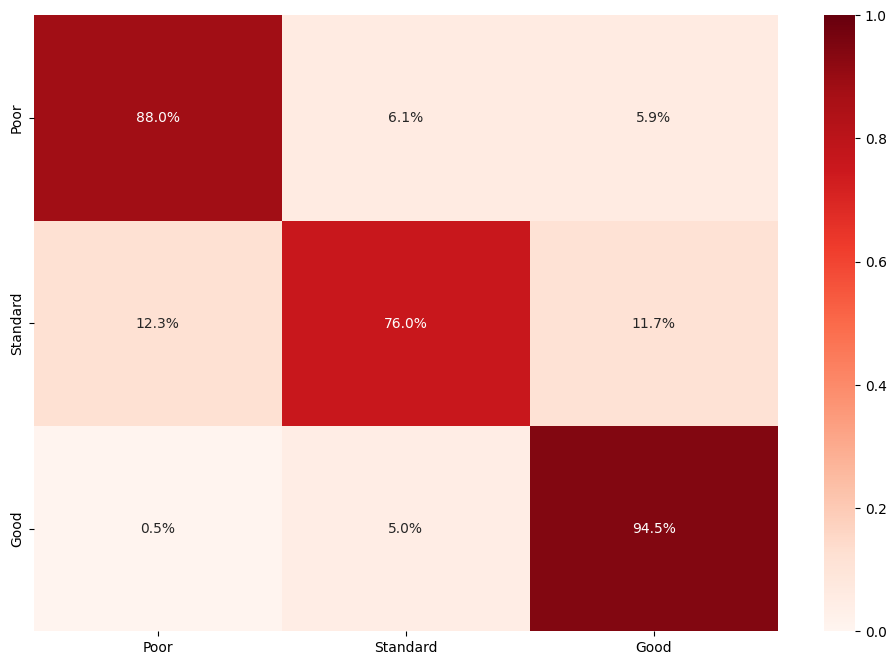

In [148]:
labels = list(credit_score_map.keys())

# calculating the percentages of correctly predicted class
pcts_ = conf_matrix / conf_matrix.sum(axis=1).reshape(3,1)

plt.figure(figsize=(12,8))
sns.heatmap(pcts_, annot=pcts_, fmt='.1%', xticklabels=labels, yticklabels=labels, cmap='Reds', vmin=0, vmax=1)
plt.show()

From the heatmap of the confusion matrix, the model found it a little bit challenging accurately predicting the `Standard` class. However, given the complexity of our data, it's fair to say that overall, the model performed well.

**Reciever operating characteristic (ROC)**

The AUC score measures a model's abiolity to disntinguish diferent classes or catgeories. It is typically used for binary classification, but can be extended to multiclass by setting it 'multi_class' argument. 

The score itself represents the probability that a randomly chosen positive sample will be ranked higher than a randomly chosen negative sample. AUC scores above 0.8 are considered excellent, and outstanding if it's above 0.9.

In [149]:
# checking the roc_auc score
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
pred_RF_bin = label_binarize(pred_RF, classes=np.unique(y_test))

auc_score = roc_auc_score(y_test, pred_RF_bin, multi_class='ovo', average='weighted')
print(f"Multi-class AUC score: {auc_score:.2%}")

Multi-class AUC score: 89.62%


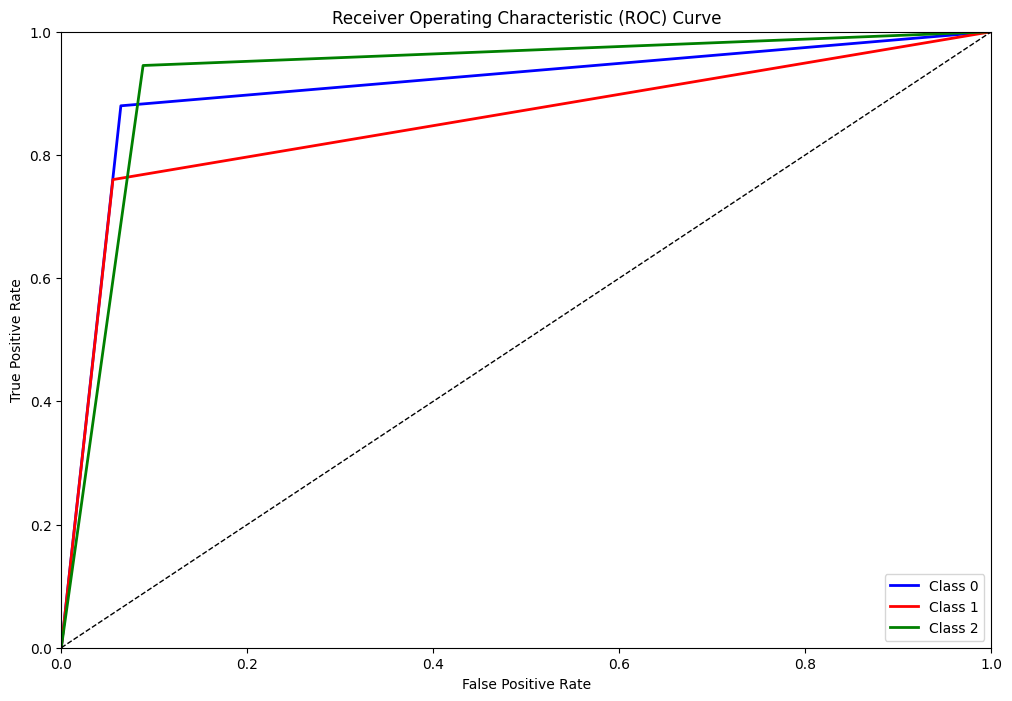

In [150]:
fpr = dict()
tpr = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_RF_bin[:, i])
    
plt.figure(figsize=(12,8))
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i}")
    
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

We have been able to create a classifier with **`precision = 86%`, `recall = 86%` & `f1-score = 86%`**. The model also has an area  under the curve score of **`~90%`**, which we can argue is outstanding. 

This model can also be improved through some hyper parameter tuning, but that wasn't performed due to the contraints of my pc and the computation time. 

Considering that we eliminated the `Customer_ID` column, in order to create a model that can generalize when depolyed in any location, in addition to the noise and outliers in the data, i think this model performs well.